# Assignment 2: Spatial Models - Networks

### Aleksandar Jacimovic, id: 15278247,  Kevin Schaaf 11058668

In [2]:
import csv
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import ndlib
import ndlib.models.epidemics as ep
import os
import pandas as pd
import scipy
from scipy.integrate import odeint     
from scipy.optimize import minimize
import seaborn as sns 
import statsmodels as sm
import sympy as sp

## Problem 1: Gillespie’s Direct Algorithm and Stochastic Hallmarks

The following code incorporates # Gillespie's Direct Algorithm as well as the standard deterministic model.

First, we write a function to solve the differential equations corresponding to the SIR model with demography and where SIRN = the current state-variable, t = time, beta = transmission rate, gamma = recovery rate, mu = birth and death rate

In [118]:
def my_ode_11(SIRN, t, beta, gamma, mu):
    S, I, R, N = SIRN
    dSdt = mu*N -beta*S*I/N - mu*S
    dIdt = beta*S*I/N - gamma*I - mu*I
    dRdt = gamma*I - mu*R
    return [dSdt, dIdt, dRdt, 0]

Next, we set the parameters and conditions

In [4]:
beta_11 = 1.8
gamma_11 = 0.1
mu_11 = 0.02
N = 10000 #Size of the population

X_0 = 0.8*N
Y_0 = 0.2*N
Z_0 = 0

SIRN0_11 = [X_0, Y_0, Z_0, N] # Make sure that these elements are integers since they represent the number of persons in that category. 

t_0 = 0
t_final = 100
t = np.linspace(t_0, t_final, 100)

In [5]:
solution_11 = odeint(my_ode_11, SIRN0_11, t, args=(beta_11, gamma_11, mu_11))
S_solution_11, I_solution_11, R_solution_11, N_solution_11 = solution_11.T

Gillespie's Direct Algorithm: box 6.3 on page 201 of the KR book

In [6]:
#step 1: label all possible events
events = ['births', 'transmission', 'recovery', 'death_in_S', 'death_in_I', 'death_in_R']       
# counter = 0  #counts the number of events that have occured
time = [0]
X = [0.8*N]
Y = [0.2*N]
Z = [0*N]

while time[-1] < t_final:
    current_X = X[-1]
    current_Y = Y[-1]
    current_Z = Z[-1]
    current_time = time[-1]
    #step 2: determine the rate at which each event occurs
    event_rates = np.array([mu_11*N, 
                            beta_11*current_X*current_Y/N, 
                            gamma_11*current_Y, 
                            mu_11*current_X, 
                            mu_11*current_Y, 
                            mu_11*current_Z])
    #step 3: the rate at which any event occurs
    rate_sum = np.sum(event_rates) 
    #step 4: the time until the next event
    delta_t = -1/rate_sum * np.log(1-np.random.uniform(0,1))  
    #step 5: generate a new random number
    p = np.random.uniform(0,1) * rate_sum                                                      
    time.append(current_time + delta_t)  
    
    if current_Y == 0 and Y[-2] != 0:
        print(f'extinction at time = {time[-1]}')                                                  
    if 0 <= p and p <= np.sum(event_rates[:1]):
        X.append(current_X + 1)
        Y.append(current_Y)
        Z.append(current_Z)
    elif np.sum(event_rates[:1]) < p and p <= np.sum(event_rates[:2]):
        Y.append(current_Y + 1)
        X.append(current_X - 1)
        Z.append(current_Z)
    elif np.sum(event_rates[:2]) < p and p <= np.sum(event_rates[:3]):
        X.append(current_X)
        Y.append(current_Y - 1)
        Z.append(current_Z + 1)
    elif np.sum(event_rates[:3]) < p and p <= np.sum(event_rates[:4]):
        X.append(current_X - 1)
        Y.append(current_Y)
        Z.append(current_Z)
    elif np.sum(event_rates[:4]) < p and p <= np.sum(event_rates[:5]):
        X.append(current_X)
        Y.append(current_Y - 1)
        Z.append(current_Z)
    elif np.sum(event_rates[:5]) < p and p <= np.sum(event_rates[:6]):
        X.append(current_X)
        Y.append(current_Y)
        Z.append(current_Z - 1)        

In [7]:
# define colors
blues = ['blue', '#6699FF']  # standard blue and light blue 
reds = ['red', '#FF6666']    # standard red and light red 
greens = ['green', '#90EE90']  # standard yellow and light yellow 

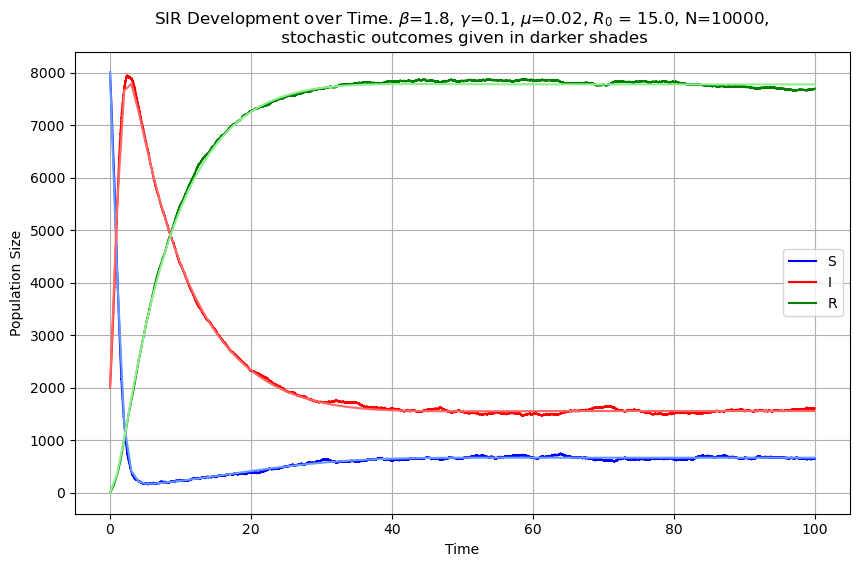

In [8]:
plt.figure(figsize=(10, 6))

# stochastic (darker)
plt.plot(time, X, label='S', color = blues[0])
plt.plot(time, Y, label='I', color = reds[0])
plt.plot(time, Z, label='R', color = greens[0])

# deterministic (lighter)
plt.plot(t, S_solution_11, color = blues[1])
plt.plot(t, I_solution_11, color = reds[1])
plt.plot(t, R_solution_11, color = greens[1])

plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title(fr'SIR Development over Time. $\beta$={beta_11}, $\gamma$={gamma_11}, $\mu$={mu_11}, $R_0$ = {beta_11/(gamma_11+mu_11)}, N={N}, {chr(10)} stochastic outcomes given in darker shades')
plt.legend()
plt.grid()
plt.show()

The deterministic model relatively quickly reaches the equillibrium. Meanwhile, in a stochastic model that convergence to lower values of indfectious individual could take longer. Additionally, due to death and birth rates, the susceptible pool can grow and the recovered pool can decrease - potentially leading to new spikes in the epidemic. 

The code incorporates the time determination if an extinction occures. Once an extintion is printed, another epidemic would not be possible. 

### Experiment 1: Variability and Covariance

In the next section we investigate the influence of varying the model parameters (beta, gamma and mu) on the stochastic behaviour of the model. We are particularly interested in the variance between runs and the covariance between S and I within runs. We will also be comparing the mean of the stochastic simulations with the deterministic output. 

In [9]:
def gillespie_sir(beta, gamma, mu, N, max_time):
    S = N - 1
    I = 1
    R = 0
    t = 0
    S_data, I_data, R_data, time_data = [S], [I], [R], [t]

    while t < max_time and I > 0:
        #step 2: determine the rate at which each event occurs
        rate_birth = mu * N
        rate_transmission = beta * S * I / N
        rate_recovery = gamma * I
        rate_death_in_S = mu * S
        rate_death_in_I = mu * I
        rate_death_in_R = mu * R
        #step 3: the rate at which any event occurs
        rates_sum = (rate_birth + rate_transmission + rate_recovery +
                     rate_death_in_S + rate_death_in_I + rate_death_in_R)
        #step 4: the time until the next event
        t += -np.log(np.random.random()) / rates_sum # -1/rate_sum * np.log(1-np.random.uniform(0,1))  
        #step 5: generate a new random number
        rand = np.random.random() * rates_sum
        # step 6: occurence of event p 
        if rand < rate_birth:
            S += 1
        elif rand < rate_birth + rate_transmission:
            S -= 1
            I += 1
        elif rand < rate_birth + rate_transmission + rate_recovery:
            I -= 1
            R += 1
        elif rand < rate_birth + rate_transmission + rate_recovery + rate_death_in_S:
            S -= 1
        elif rand < rate_birth + rate_transmission + rate_recovery + rate_death_in_S + rate_death_in_I:
            I -= 1
        else:
            R -= 1

        S_data.append(S)
        I_data.append(I)
        R_data.append(R)
        time_data.append(t)

    return np.array(S_data), np.array(I_data), np.array(R_data), np.array(time_data)


In [10]:
# set up parameter ranges
beta_values = np.linspace(0.1, 3.0, 50)  # infection rate
gamma_values = np.linspace(0.1, 1.0, 20)  # recovery rate
mu_values = np.linspace(0.01, 0.1, 10)  # birth/death rate
iterations = 10  # number of iterations per parameter combination
N = 1000  # total population
max_time = 200  # maximum simulation time

In [11]:
# collect statistics for each parameter combination
time_series_data_deterministic = []
time_series_data_stochastic = []
results = []

for beta in beta_values:
    for gamma in gamma_values:
        for mu in mu_values:
            
            X_0 = N-1
            Y_0 = 1
            Z_0 = 0
            SIRN_0 = [X_0, Y_0, Z_0, N] 
            
            t = np.linspace(0, max_time, max_time)
            
            det_solution = odeint(my_ode_11, SIRN_0, t, args=(beta, gamma, mu))    
            S_solution, I_solution, R_solution, N_solution = det_solution.T
            
            # make sure the data arrays are all of the length max_time
            len_diff = max_time - len(S_solution)
            if len_diff > 0:
               # extend the arrays if too short
                S_solution = np.pad(S_solution, (0, len_diff), 'constant', constant_values=(S_solution[-1],))
                I_solution = np.pad(I_solution, (0, len_diff), 'constant', constant_values=(I_solution[-1],))
                R_solution = np.pad(R_solution, (0, len_diff), 'constant', constant_values=(R_solution[-1],))
            elif len_diff < 0:
                # cut if they too long
                S_solution = S_solution[:max_time]
                I_solution = I_solution[:max_time]
                R_solution = R_solution[:max_time]
            
            S_agg = np.zeros(max_time)
            I_agg = np.zeros(max_time)
            R_agg = np.zeros(max_time)
            
            variance_S = []
            std_S = []
            variance_I = []
            std_I = []
            covariances_SI = []
            
            for iteration in range(iterations):
                S_data, I_data, R_data, time_data = gillespie_sir(beta, gamma, mu, N, max_time)
                
                # make sure the data arrays are all of the length max_time
                len_diff = max_time - len(S_data)
                if len_diff > 0:
                    # extend the arrays if too short
                    S_data = np.pad(S_data, (0, len_diff), 'constant', constant_values=(S_data[-1],))
                    I_data = np.pad(I_data, (0, len_diff), 'constant', constant_values=(I_data[-1],))
                    R_data = np.pad(R_data, (0, len_diff), 'constant', constant_values=(R_data[-1],))
                    time_data = np.pad(time_data, (0, len_diff), 'constant', constant_values=(time_data[-1],))
                elif len_diff < 0:
                    # cut if they too long
                    S_data = S_data[:max_time]
                    I_data = I_data[:max_time]
                    R_data = R_data[:max_time]
                    time_data = time_data[:max_time]

                S_agg += S_data
                I_agg += I_data
                R_agg += R_data
                
                variance_S.append(np.var(S_data))
                std_S.append(np.std(S_data))
                variance_I.append(np.var(I_data))
                std_I.append(np.std(I_data))
                covariances_SI.append(np.cov(S_data, I_data)[0, 1])
            
            # calculate means
            S_mean = S_agg / iterations
            I_mean = I_agg / iterations
            R_mean = R_agg / iterations
            
            # append to the list
            time_series_data_deterministic.append({
                'beta': beta,
                'gamma': gamma,
                'mu': mu,
                'S_solution': S_solution,
                'I_solution': I_solution,
                'R_solution': R_solution,
                'time': time_data
            })
            
            time_series_data_stochastic.append({
                'beta': beta,
                'gamma': gamma,
                'mu': mu,
                'S_mean': S_mean,
                'I_mean': I_mean,
                'R_mean': R_mean,
                'time': time_data
            })
            
            # calculate variable means across parameter iterations
            mean_variance_S = np.mean(variance_S)
            mean_std_S = np.mean(std_S)
            mean_variance_I = np.mean(variance_I)
            mean_std_I = np.mean(std_I)
            mean_covariance_SI = np.mean(covariances_SI)
            # results
            results.append({
                'beta': beta,
                'gamma': gamma,
                'mu': mu,
                'mean_variance_S': mean_variance_S, 
                'mean_std_S': mean_std_S, 
                'mean_variance_I': mean_variance_I, 
                'mean_std_I': mean_std_I, 
                'mean_covariance_SI': mean_covariance_SI
            })

In [12]:
# convert the results to a df
df_deterministic = pd.DataFrame(time_series_data_deterministic)
df_stochastic = pd.DataFrame(time_series_data_stochastic)
df_results = pd.DataFrame(results)

# calculate R0s
df_results['R0'] = df_results['beta'] / (df_results['gamma'] + df_results['mu'])

In [13]:
display(df_deterministic)

,beta,gamma,mu,S_solution,I_solution,R_solution,time
0,0.1,0.1,0.01,"[999.0, 998.9106115105126, 998.8231302684256, ...","[1.0, 0.9898961285323921, 0.9798856366107189, ...","[0.0, 0.09949236095505244, 0.19698409496365266...","[0.0, 0.016814928384738415, 0.0713052560994604..."
1,0.1,0.1,0.02,"[999.0, 998.9215047647141, 998.8465474850487, ...","[1.0, 0.9799977722742885, 0.960388229666559, 0...","[0.0, 0.09849746301161871, 0.19306428528586564...","[0.0, 0.1013371524357706, 0.13043528795002612,..."
2,0.1,0.1,0.03,"[999.0, 998.9322890961926, 998.8694987787542, ...","[1.0, 0.9701983901300437, 0.941278746644525, 0...","[0.0, 0.09751251367719171, 0.1892224746010202,...","[0.0, 0.005273139651229893, 0.0317882731484681..."
3,0.1,0.1,0.04,"[999.0, 998.942965619446, 998.8919934413748, 9...","[1.0, 0.960496996223637, 0.9225494737899691, 0...","[0.0, 0.09653738433025011, 0.1854570848351345,...","[0.0, 0.017308517858525014, 0.0333863110275632..."
4,0.1,0.1,0.05,"[999.0, 998.9535353601672, 998.9140405100894, ...","[1.0, 0.9508926041701035, 0.904192841091765, 0...","[0.0, 0.0955720356629274, 0.18176664881906987,...","[0.0, 0.004879773420401743, 0.0201715938038326..."
...,...,...,...,...,...,...,...
9995,3.0,1.0,0.06,"[999.0, 990.0356737526403, 932.5259044830744, ...","[1.0, 6.9399752928607645, 44.47070367125235, 1...","[0.0, 3.0243509544988143, 23.003391845673388, ...","[0.0, 0.019033394685227346, 0.0530550692802929..."
9996,3.0,1.0,0.07,"[999.0, 990.1346488487576, 933.7862407813968, ...","[1.0, 6.87114831748985, 43.65309306407645, 184...","[0.0, 2.9942028337526696, 22.560666154526995, ...","[0.0, 0.005347821605388669, 0.0053478216053886..."
9997,3.0,1.0,0.08,"[999.0, 990.2326457419033, 935.0242308498848, ...","[1.0, 6.802999615821885, 42.849506360024755, 1...","[0.0, 2.9643546422747984, 22.12626279009031, 1...","[0.0, 0.0008739533416435786, 0.002108867210908..."
9998,3.0,1.0,0.09,"[999.0, 990.3296740127707, 936.2402308046796, ...","[1.0, 6.73552258093401, 42.05973744389154, 177...","[0.0, 2.9348034062952175, 21.700031751428977, ...","[0.0, 0.0014821354438647163, 0.003555923220246..."


In [14]:
display(df_stochastic)

,beta,gamma,mu,S_mean,I_mean,R_mean,time
0,0.1,0.1,0.01,"[999.0, 999.2, 999.1, 998.7, 998.5, 998.7, 998...","[1.0, 1.0, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, ...","[0.0, 0.0, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...","[0.0, 0.016814928384738415, 0.0713052560994604..."
1,0.1,0.1,0.02,"[999.0, 998.8, 998.4, 998.2, 998.0, 997.6, 997...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.1013371524357706, 0.13043528795002612,..."
2,0.1,0.1,0.03,"[999.0, 999.2, 999.4, 998.8, 998.8, 999.0, 999...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.005273139651229893, 0.0317882731484681..."
3,0.1,0.1,0.04,"[999.0, 999.2, 999.0, 999.4, 999.4, 999.6, 999...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.017308517858525014, 0.0333863110275632..."
4,0.1,0.1,0.05,"[999.0, 999.0, 999.4, 999.0, 999.2, 999.2, 999...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.004879773420401743, 0.0201715938038326..."
...,...,...,...,...,...,...,...
9995,3.0,1.0,0.06,"[999.0, 998.6, 998.2, 997.8, 997.4, 997.3, 996...","[1.0, 1.0, 1.2, 1.2, 1.2, 1.2, 1.1, 1.2, 1.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.2, 0.2, ...","[0.0, 0.019033394685227346, 0.0530550692802929..."
9996,3.0,1.0,0.07,"[999.0, 998.9, 999.2, 998.7, 998.8, 998.5, 998...","[1.0, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, ...","[0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...","[0.0, 0.005347821605388669, 0.0053478216053886..."
9997,3.0,1.0,0.08,"[999.0, 998.8, 999.4, 999.6, 999.8, 999.8, 100...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, ...","[0.0, 0.0008739533416435786, 0.002108867210908..."
9998,3.0,1.0,0.09,"[999.0, 999.0, 999.0, 999.2, 999.2, 998.8, 999...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0014821354438647163, 0.003555923220246..."


Find the parameters with the best and the worst fits between the deterministic and mean stochastic outcome

In [18]:
from sklearn.metrics import mean_squared_error

In [37]:
det_t = df_deterministic[(df_deterministic['beta'] == beta) & 
                         (df_deterministic['gamma'] == gamma) & 
                         (df_deterministic['mu'] == mu)]
stoch_t = df_stochastic[(df_stochastic['beta'] == beta) & 
                        (df_stochastic['gamma'] == gamma) & 
                        (df_stochastic['mu'] == mu)]

In [38]:
display(det_t)

,beta,gamma,mu,S_solution,I_solution,R_solution,time
9999,3.0,1.0,0.1,"[999.0, 990.4257431497404, 937.4345924233957, ...","[1.0, 6.668710668891163, 41.28358203905077, 17...","[0.0, 2.905546181368378, 21.28182553755347, 11...","[0.0, 0.0027441889215979206, 0.009290603839558..."


In [39]:
display(stoch_t)

,beta,gamma,mu,S_mean,I_mean,R_mean,time
9999,3.0,1.0,0.1,"[999.0, 998.4, 998.2, 998.2, 998.2, 998.5, 998...","[1.0, 1.0, 1.1, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.1, ...","[0.0, 0.0027441889215979206, 0.009290603839558..."


In [19]:
# compute the MSE for each parameter set
for item in results:
    beta = item['beta']
    gamma = item['gamma']
    mu = item['mu']
    
    # filter the deterministic and stochastic data for the current set of parameters
    det = df_deterministic[(df_deterministic['beta'] == beta) & 
                           (df_deterministic['gamma'] == gamma) & 
                           (df_deterministic['mu'] == mu)]
    stoch = df_stochastic[(df_stochastic['beta'] == beta) & 
                          (df_stochastic['gamma'] == gamma) & 
                          (df_stochastic['mu'] == mu)]
    
    # compute MSE for S and I between deterministic and stochastic models
    mse_S = mean_squared_error(det['S_solution'].values[0], stoch['S_mean'].values[0])
    mse_I = mean_squared_error(det['I_solution'].values[0], stoch['I_mean'].values[0])
    
    # update the results dictionary with the MSE values
    item['mse_S'] = mse_S
    item['mse_I'] = mse_I

In [ ]:
# sort the results by the sum of mse_S and mse_I to find the lowest and highest MSE
results_sorted = sorted(results, key=lambda x: (x['mse_S'] + x['mse_I']))
lowest_mse = results_sorted[0]
highest_mse = results_sorted[-1]

In [67]:
df_results_updated = pd.DataFrame(results)
# calculate R0s
df_results_updated['R0'] = df_results_updated['beta'] / (df_results_updated['gamma'] + df_results_updated['mu'])
df_results_updated['MSE_sum'] = df_results_updated['mse_S']+df_results_updated['mse_I']

In [68]:
display(df_results_updated)

,beta,gamma,mu,mean_variance_S,mean_std_S,mean_variance_I,mean_std_I,mean_covariance_SI,mse_S,mse_I,R0,MSE_sum
0,0.1,0.1,0.01,30.674767,4.367055,0.278310,0.424595,-0.737721,8.737196,0.212681,0.909091,8.949877
1,0.1,0.1,0.02,21.848193,4.388711,0.136887,0.306332,0.194563,5.036426,0.580533,0.833333,5.616959
2,0.1,0.1,0.03,17.618507,3.996401,0.071063,0.178618,-0.107073,12.881001,0.598788,0.769231,13.479789
3,0.1,0.1,0.04,47.040790,6.574449,0.056677,0.122357,0.351533,1.898971,0.911825,0.714286,2.810795
4,0.1,0.1,0.05,20.774368,4.237845,0.047915,0.117775,0.321666,4.373772,0.605665,0.666667,4.979437
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.0,1.0,0.06,59.570262,6.463266,20.580448,3.667457,-27.773229,403892.026248,1805.862177,2.830189,405697.888426
9996,3.0,1.0,0.07,25.090495,3.854995,5.027595,1.481760,-5.320244,404762.267788,2447.753284,2.803738,407210.021072
9997,3.0,1.0,0.08,21.383800,3.761268,4.927848,1.715113,-1.967254,407892.108576,2845.184523,2.777778,410737.293099
9998,3.0,1.0,0.09,26.356968,4.651063,3.029765,1.302848,-4.078397,400538.556141,3316.389482,2.752294,403854.945623


In [115]:
# calculate the max value of R_0 considered across all parametrisations 
max(df_results_updated['R0'])

27.272727272727273

#### Plotting

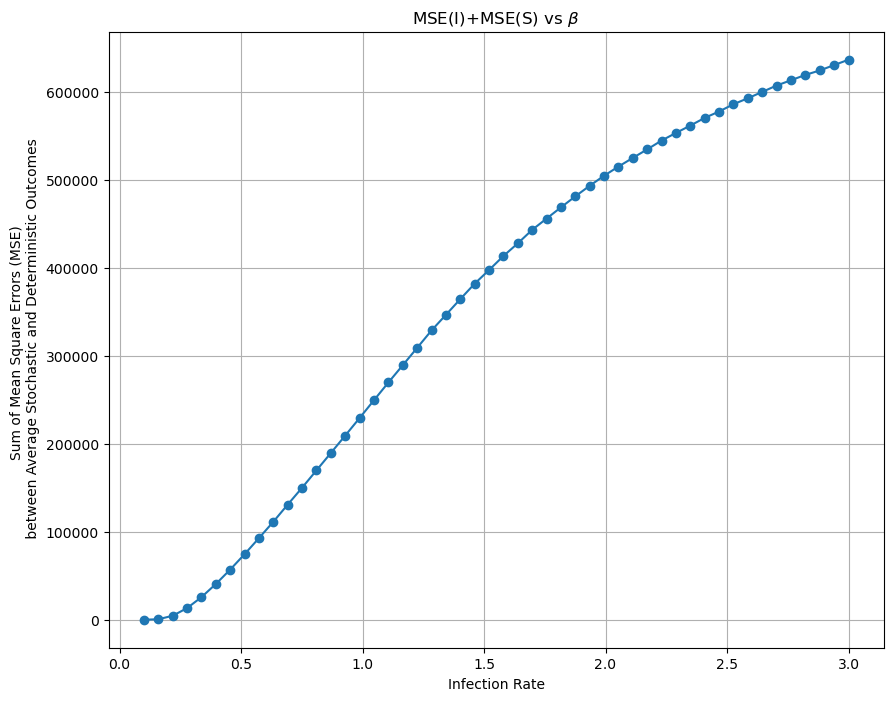

In [80]:
# divergence between S and I for various values of beta based on the sum of MSE(S) and MSE(I)
plt.figure(figsize=(10, 8))
df_beta = df_results_updated.groupby('beta')['MSE_sum'].mean().reset_index()
plt.plot(df_beta['beta'], df_beta['MSE_sum'], marker='o')
plt.xlabel('Infection Rate')
plt.ylabel(fr'Sum of Mean Square Errors (MSE) {chr(10)} between Average Stochastic and Deterministic Outcomes')
plt.title(fr'MSE(I)+MSE(S) vs $\beta$')
plt.grid(True)
plt.show()

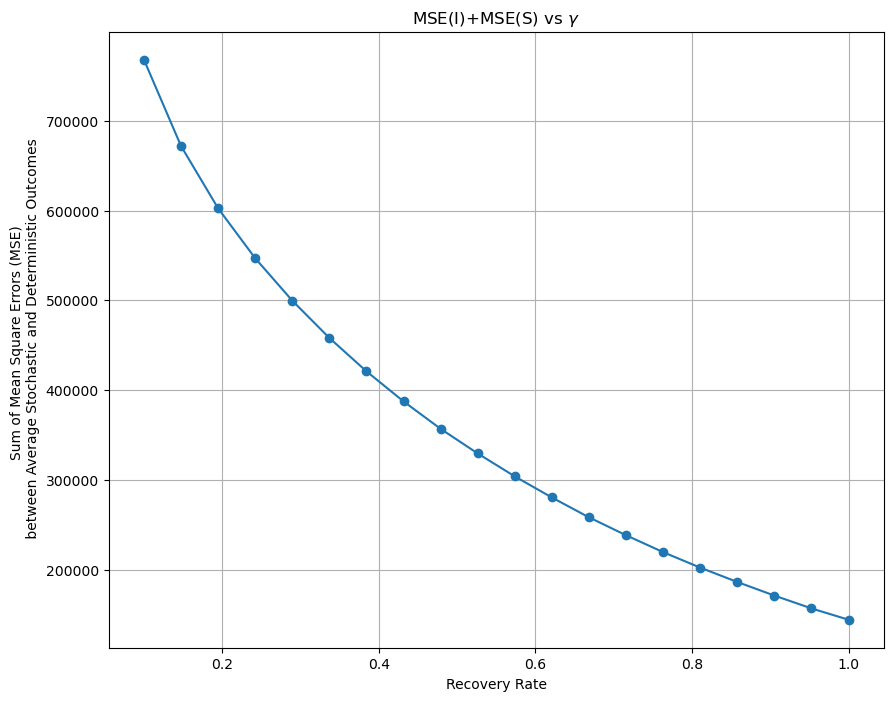

In [82]:
# divergence between S and I for various values of gamma based on the sum of MSE(S) and MSE(I)
plt.figure(figsize=(10, 8))
df_gamma = df_results_updated.groupby('gamma')['MSE_sum'].mean().reset_index()
plt.plot(df_gamma['gamma'], df_gamma['MSE_sum'], marker='o')
plt.xlabel('Recovery Rate')
plt.ylabel(fr'Sum of Mean Square Errors (MSE) {chr(10)} between Average Stochastic and Deterministic Outcomes')
plt.title(fr'MSE(I)+MSE(S) vs $\gamma$')
plt.grid(True)
plt.show()

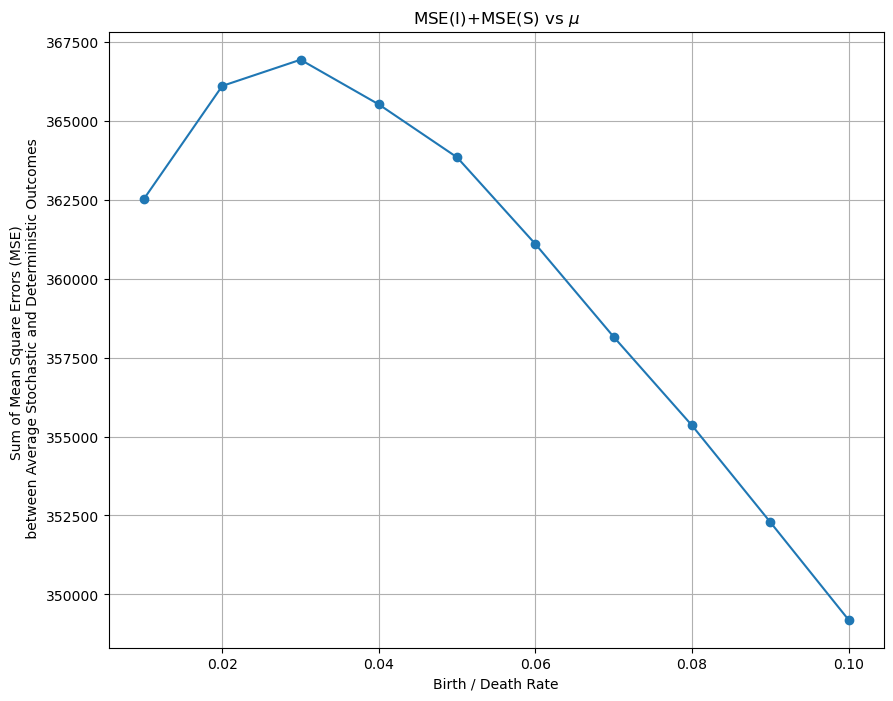

In [83]:
# divergence between S and I for various values of mu based on the sum of MSE(S) and MSE(I)
plt.figure(figsize=(10, 8))
df_mu = df_results_updated.groupby('mu')['MSE_sum'].mean().reset_index()
plt.plot(df_mu['mu'], df_mu['MSE_sum'], marker='o')
plt.xlabel('Birth / Death Rate')
plt.ylabel(fr'Sum of Mean Square Errors (MSE) {chr(10)} between Average Stochastic and Deterministic Outcomes')
plt.title(fr'MSE(I)+MSE(S) vs $\mu$')
plt.grid(True)
plt.show()

In [84]:
# plot the comparison cases between stochastic and deterministic 
def plot_sir_comparison(det, stoch, title):
    min_length = min(len(det['time']), len(stoch['time']))
    time = det['time'][:min_length]
    S_det = det['S_solution'][:min_length]
    I_det = det['I_solution'][:min_length]
    R_det = det['R_solution'][:min_length]
    S_stoch = stoch['S_mean'][:min_length]
    I_stoch = stoch['I_mean'][:min_length]
    R_stoch = stoch['R_mean'][:min_length]
    
    plt.figure(figsize=(12, 6))

    # deterministic data
    plt.plot(time, S_det, label='S (Deterministic)', color= blues[1])
    plt.plot(time, I_det, label='I (Deterministic)', color= reds[1])
    plt.plot(time, R_det, label='R (Deterministic)', color= greens[1])

    # stochastic data
    plt.plot(time, S_stoch, label='S (Stochastic)', linestyle='--', color= blues[0])
    plt.plot(time, I_stoch, label='I (Stochastic)', linestyle='--', color= reds[0])
    plt.plot(time, R_stoch, label='R (Stochastic)', linestyle='--', color= greens[0])

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.legend(loc='center right')
    plt.grid(True)
    plt.show()

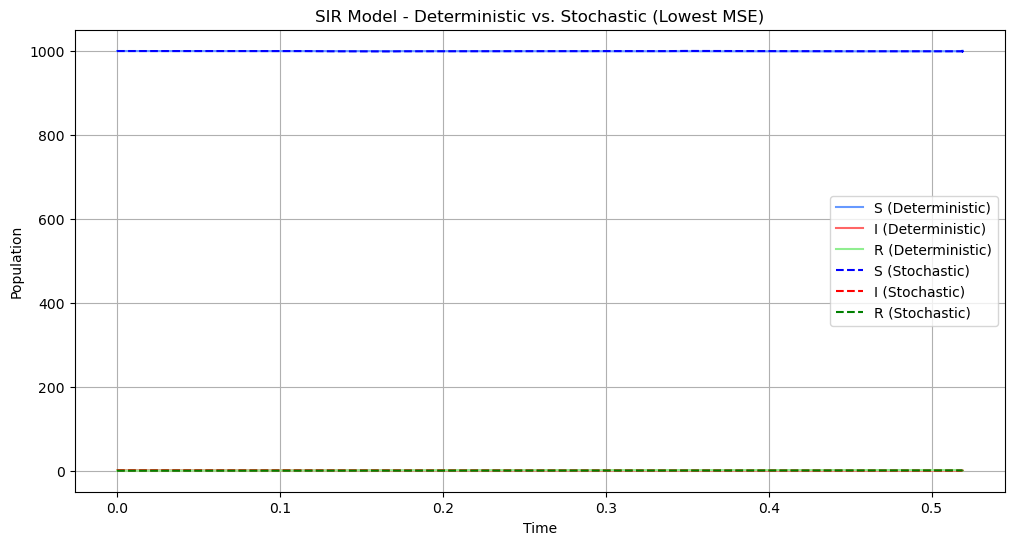

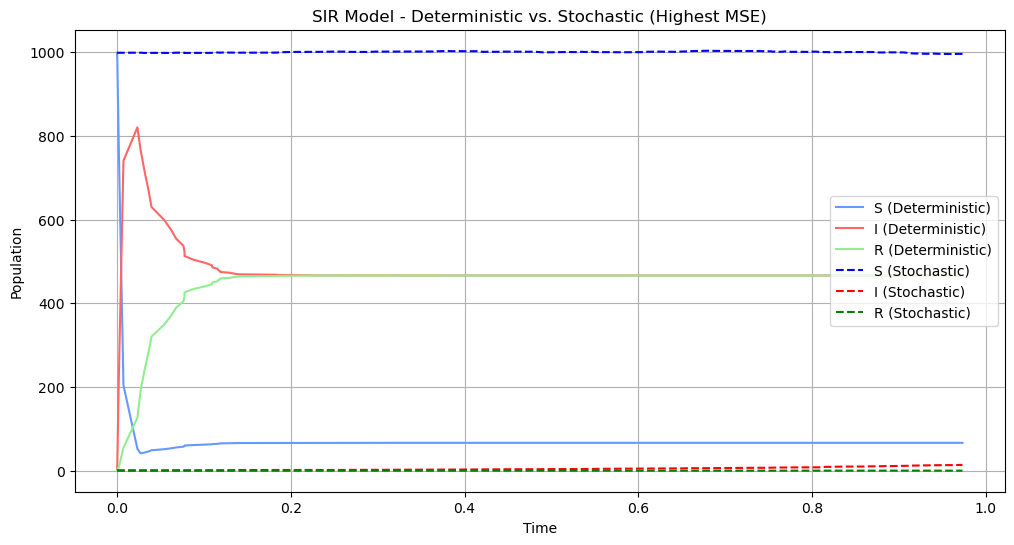

In [85]:
# Plot for the lowest MSE
det_lowest = df_deterministic[(df_deterministic['beta'] == lowest_mse['beta']) & 
                              (df_deterministic['gamma'] == lowest_mse['gamma']) & 
                              (df_deterministic['mu'] == lowest_mse['mu'])].iloc[0]
stoch_lowest = df_stochastic[(df_stochastic['beta'] == lowest_mse['beta']) & 
                             (df_stochastic['gamma'] == lowest_mse['gamma']) & 
                             (df_stochastic['mu'] == lowest_mse['mu'])].iloc[0]
plot_sir_comparison(det_lowest, stoch_lowest, 'SIR Model - Deterministic vs. Stochastic (Lowest MSE)')

# Plot for the highest MSE
det_highest = df_deterministic[(df_deterministic['beta'] == highest_mse['beta']) & 
                               (df_deterministic['gamma'] == highest_mse['gamma']) & 
                               (df_deterministic['mu'] == highest_mse['mu'])].iloc[0]
stoch_highest = df_stochastic[(df_stochastic['beta'] == highest_mse['beta']) & 
                               (df_stochastic['gamma'] == highest_mse['gamma']) & 
                               (df_stochastic['mu'] == highest_mse['mu'])].iloc[0]

plot_sir_comparison(det_highest, stoch_highest, 'SIR Model - Deterministic vs. Stochastic (Highest MSE)')

In [86]:
# parameter set generating the highest MSE sum 
print(highest_mse['beta'],highest_mse['gamma'],highest_mse['mu'])

3.0 0.1 0.1


In [88]:
# parameter set generating the lowest MSE sum 
print(round(lowest_mse['beta'],2),round(lowest_mse['gamma'],2), round(lowest_mse['mu'],2))

0.28 0.57 0.01


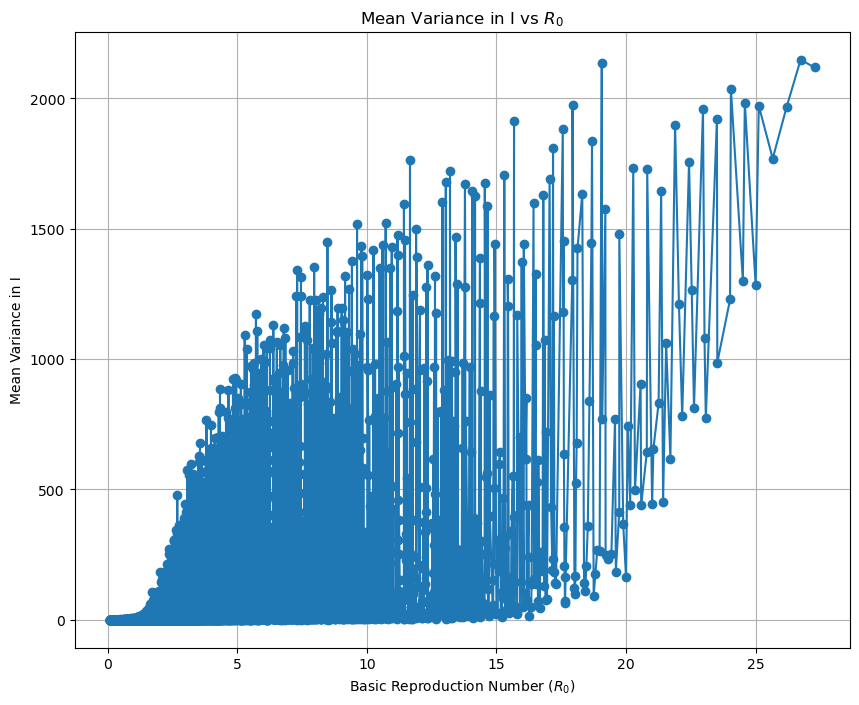

In [113]:
# mean variance in I for various values of R_0
plt.figure(figsize=(10, 8))
df_R0 = df_results.groupby('R0')['mean_variance_I'].mean().reset_index()
plt.plot(df_R0['R0'], df_R0['mean_variance_I'], marker='o')
plt.xlabel(fr'Basic Reproduction Number ($R_0$)')
plt.ylabel('Mean Variance in I')
plt.title(fr'Mean Variance in I vs $R_0$')
plt.grid(True)
plt.show()

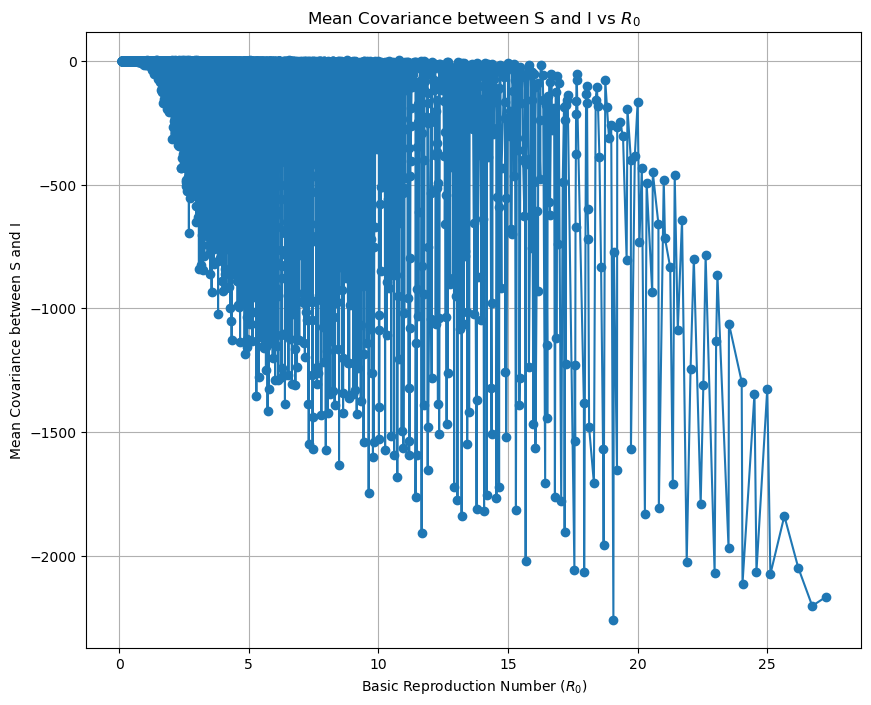

In [114]:
# mean covariance between S and I for various values of R_0
plt.figure(figsize=(10, 8))
df_R0 = df_results.groupby('R0')['mean_covariance_SI'].mean().reset_index()
plt.plot(df_R0['R0'], df_R0['mean_covariance_SI'], marker='o')
plt.xlabel(fr'Basic Reproduction Number ($R_0$)')
plt.ylabel('Mean Covariance between S and I')
plt.title(fr'Mean Covariance between S and I vs $R_0$')
plt.grid(True)
plt.show()

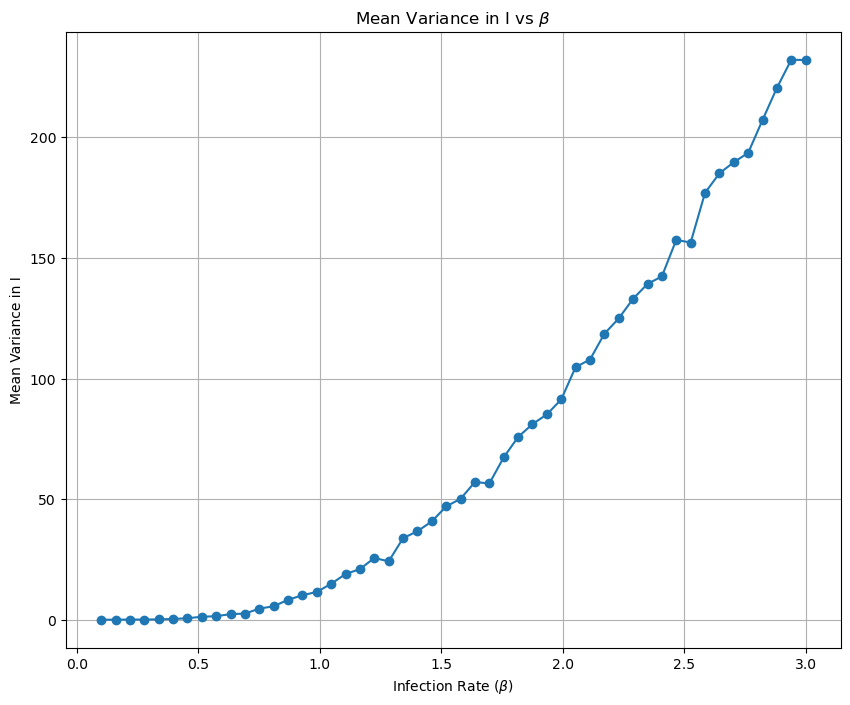

In [107]:
# mean variance in I for each value of beta
plt.figure(figsize=(10, 8))
df_beta = df_results.groupby('beta')['mean_variance_I'].mean().reset_index()
plt.plot(df_beta['beta'], df_beta['mean_variance_I'], marker='o')
plt.xlabel(fr'Infection Rate ($\beta$)')
plt.ylabel('Mean Variance in I')
plt.title(fr'Mean Variance in I vs $\beta$')
plt.grid(True)
plt.show()

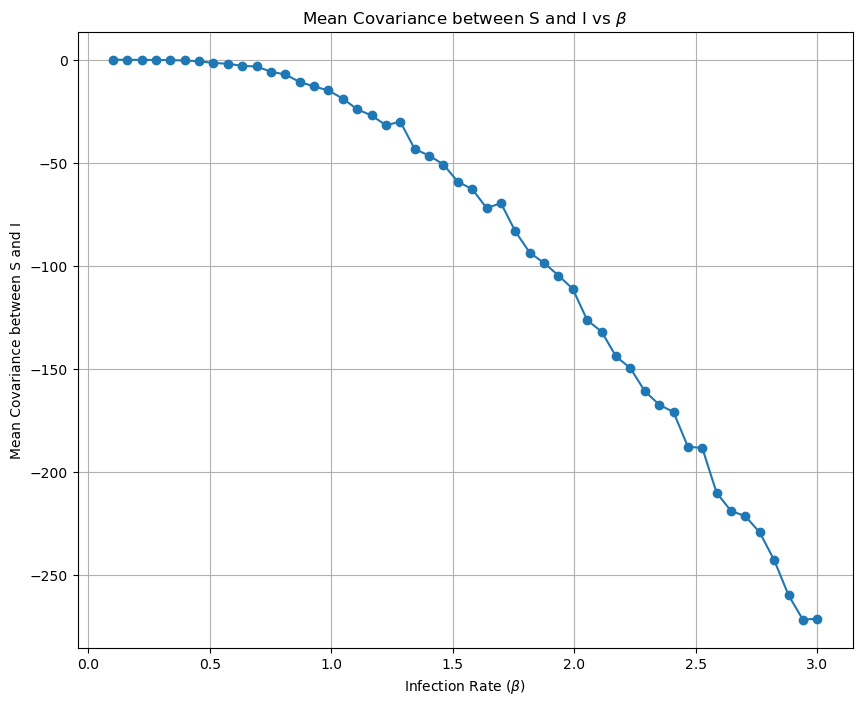

In [108]:
# mean covariance between S and I for each value of beta
plt.figure(figsize=(10, 8))
df_beta = df_results.groupby('beta')['mean_covariance_SI'].mean().reset_index()
plt.plot(df_beta['beta'], df_beta['mean_covariance_SI'], marker='o')
plt.xlabel(fr'Infection Rate ($\beta$)')
plt.ylabel('Mean Covariance between S and I')
plt.title(fr'Mean Covariance between S and I vs $\beta$')
plt.grid(True)
plt.show()

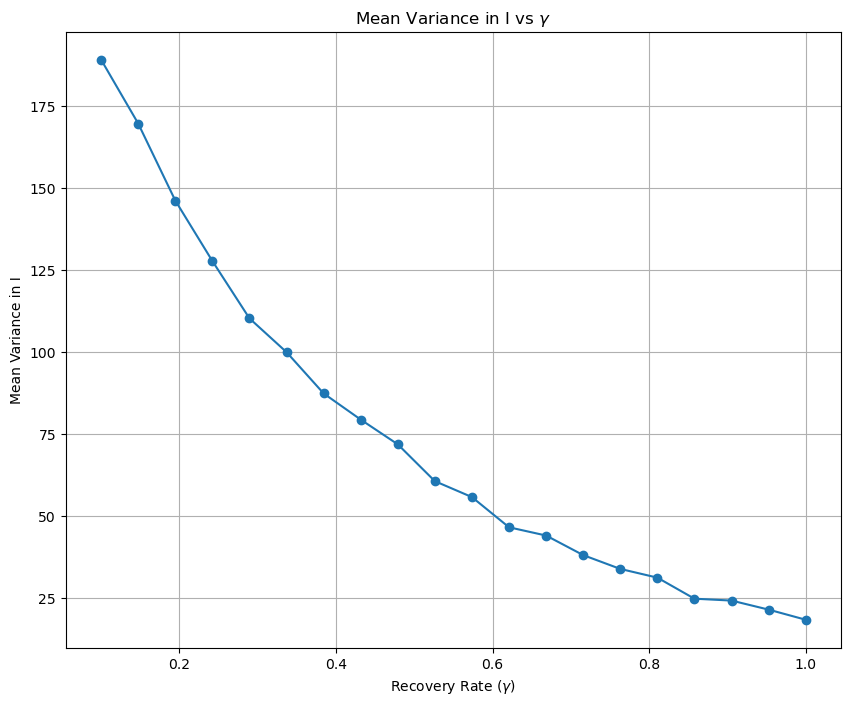

In [109]:
# mean variance in I for each value of gamma
plt.figure(figsize=(10, 8))
df_gamma = df_results.groupby('gamma')['mean_variance_I'].mean().reset_index()
plt.plot(df_gamma['gamma'], df_gamma['mean_variance_I'], marker='o')
plt.xlabel(fr'Recovery Rate ($\gamma$)')
plt.ylabel('Mean Variance in I')
plt.title(fr'Mean Variance in I vs $\gamma$')
plt.grid(True)
plt.show()

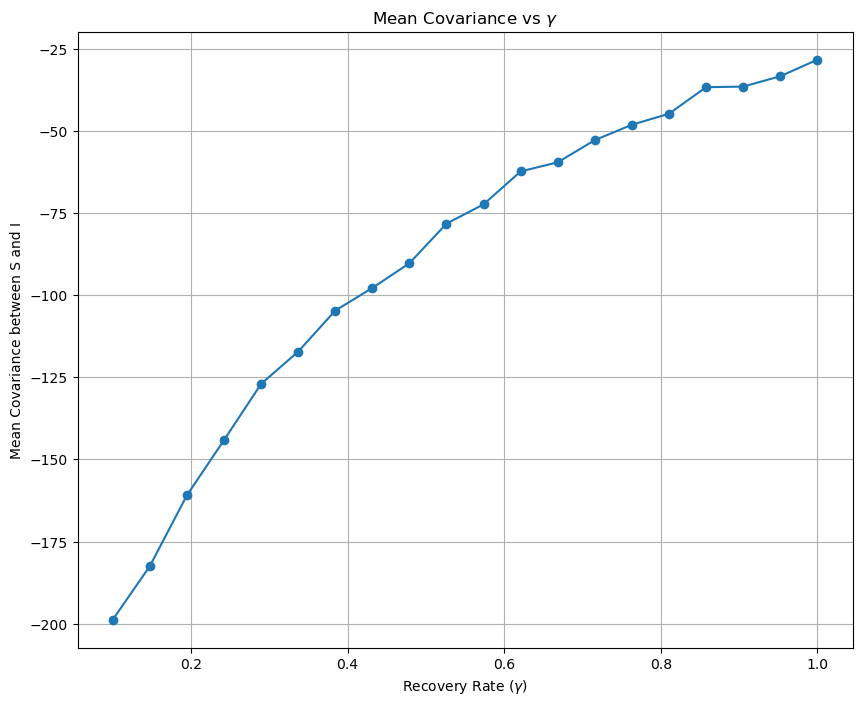

In [110]:
# mean covariance between S and I for each value of gamma
plt.figure(figsize=(10, 8))
df_gamma = df_results.groupby('gamma')['mean_covariance_SI'].mean().reset_index()
plt.plot(df_gamma['gamma'], df_gamma['mean_covariance_SI'], marker='o')
plt.xlabel(fr'Recovery Rate ($\gamma$)')
plt.ylabel('Mean Covariance between S and I')
plt.title(fr'Mean Covariance vs $\gamma$')
plt.grid(True)
plt.show()

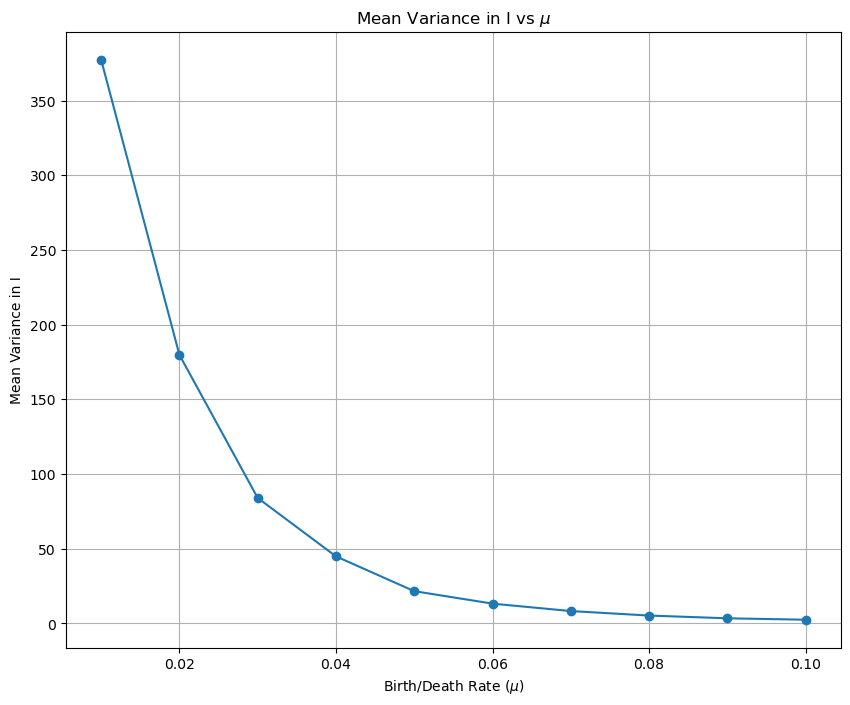

In [111]:
# mean variance in I for each value of mu
plt.figure(figsize=(10, 8))
df_mu = df_results.groupby('mu')['mean_variance_I'].mean().reset_index()
plt.plot(df_mu['mu'], df_mu['mean_variance_I'], marker='o')
plt.xlabel(fr'Birth/Death Rate ($\mu$)')
plt.ylabel('Mean Variance in I')
plt.title(fr'Mean Variance in I vs $\mu$')
plt.grid(True)
plt.show()

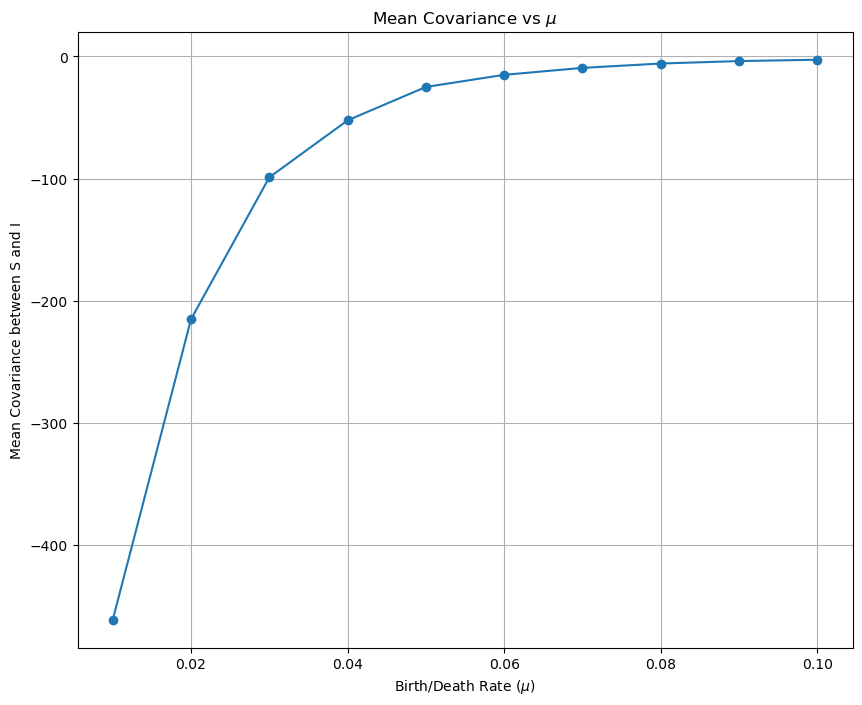

In [112]:
# mean covariance between S and I for each value of mu
plt.figure(figsize=(10, 8))
df_mu = df_results.groupby('mu')['mean_covariance_SI'].mean().reset_index()
plt.plot(df_mu['mu'], df_mu['mean_covariance_SI'], marker='o')
plt.xlabel(fr'Birth/Death Rate ($\mu$)')
plt.ylabel('Mean Covariance between S and I')
plt.title(fr'Mean Covariance vs $\mu$')
plt.grid(True)
plt.show()

Alternative (old) implementation of the algorithm 

In [ ]:
N = 10000 # population size 
X_0 = 0.8*N
Y_0 = 0.2*N
Z_0 = 0

SIRN0_12 = [X_0, Y_0, Z_0, N] # should have integer values

t_0 = 0
t_final = 100
t = np.linspace(t_0, t_final, 100)

In [ ]:
counter = 1
runs = 10

# store data for all runs in a list
reference = [1,50,99]

for i in range(2):
    beta_12 = 0.8 * (i + 1)
    for j in range(2):
        gamma_12 = 0.3 * (j + 1)
        for k in range(2):
            storage_X1 = []
            storage_Y1 = []
            storage_Z1 = []
            
            storage_X50 = []
            storage_Y50 = []
            storage_Z50 = []
            
            storage_X99 = []
            storage_Y99 = []
            storage_Z99 = []
            
            storage_covariance =[]
            
            mean_X1 = []
            var_X1 = []
            
            mean_Y1 = []
            var_Y1 = []
            
            mean_Z1 = []
            var_Z1 = []
            
            mean_X50 = []
            var_X50 = []
            
            mean_Y50 = []
            var_Y50 = []
            
            mean_Z50 = []
            var_Z50 = []
            
            mean_X99 = []
            var_X99 = []
            
            mean_Y99 = []
            var_Y99 = []
            
            mean_Z99 = []
            var_Z99 = []
            
            mu_12 = 0.01 * (k + 1)
            solution_12 = odeint(my_ode_11, SIRN0_12, t, args=(beta_12, gamma_12, mu_12))
            S_solution_12, I_solution_12, R_solution_12, N_solution_12 = solution_12.T
            extinction = False
            
            for m in range(runs):
                time = [0]
                X = [0.8 * N]
                Y = [0.2 * N]
                Z = [0]
                while time[-1] < t_final:
                    event_rates = np.array([mu_12 * N, beta_12 * X[-1] * Y[-1] / N, 
                                            gamma_12 * Y[-1], 
                                            mu_12 * X[-1], 
                                            mu_12 * Y[-1], 
                                            mu_12 * Z[-1]])
                    rate_sum = np.sum(event_rates)
                    delta_t = -1 / rate_sum * np.log(1 - np.random.uniform(0, 1))
                    p = np.random.uniform(0, 1) * rate_sum
                    time.append(time[-1] + delta_t)
                    if 0 < p and p <= np.sum(event_rates[:1]):
                        X.append(X[-1] + 1)
                        Y.append(Y[-1])
                        Z.append(Z[-1])
                    elif np.sum(event_rates[:1]) < p and p <= np.sum(event_rates[:2]):
                        X.append(X[-1] - 1)
                        Y.append(Y[-1] + 1)
                        Z.append(Z[-1])
                    elif np.sum(event_rates[:2]) < p and p <= np.sum(event_rates[:3]):
                        X.append(X[-1])
                        Y.append(Y[-1] - 1)
                        Z.append(Z[-1] + 1)
                    elif np.sum(event_rates[:3]) < p and p <= np.sum(event_rates[:4]):
                        X.append(X[-1] - 1)
                        Y.append(Y[-1])
                        Z.append(Z[-1])
                    elif np.sum(event_rates[:4]) < p and p <= np.sum(event_rates[:5]):
                        X.append(X[-1])
                        Y.append(Y[-1] - 1)
                        Z.append(Z[-1])
                    elif np.sum(event_rates[:5]) < p and p <= np.sum(event_rates[:6]):
                        X.append(X[-1])
                        Y.append(Y[-1])
                        Z.append(Z[-1] - 1)
                    # Save the values of x,y and z around timepoints 1, 50 and 99. 
                    if time[-2]< 1 and time[-1]>= 1:
                        storage_X1.append(X[-1])
                        storage_Y1.append(Y[-1])
                        storage_Z1.append(Z[-1])
                    if time[-2]< 50 and time[-1]>= 50:
                        storage_X50.append(X[-1])
                        storage_Y50.append(Y[-1])
                        storage_Z50.append(Z[-1])
                    if time[-2]< 99 and time[-1]>= 99:
                        storage_X99.append(X[-1])
                        storage_Y99.append(Y[-1])
                        storage_Z99.append(Z[-1])
                        
                #calculation of covariance between number of susceptibles and number of infectious 
                covariance_matrix = np.cov(X, Y)
                covariance = covariance_matrix[0,1]
                print(covariance)
                storage_covariance.append(covariance)
                
            mean_X1 = np.mean(storage_X1)
            var_X1 = np.std(storage_X1)
            
            mean_Y1 = np.mean(storage_Y1)
            var_Y1 = np.std(storage_Y1)
            
            mean_Z1 = np.mean(storage_Z1)
            var_Z1 = np.std(storage_Z1)
            
            mean_X50 = np.mean(storage_X50)
            var_X50 = np.std(storage_X50)            
            
            mean_Y50 = np.mean(storage_Y50)
            var_Y50 = np.std(storage_Y50)            
            
            mean_Z50 = np.mean(storage_Z50)
            var_Z50 = np.std(storage_Z50)            
            
            mean_X99 = np.mean(storage_X99)
            var_X99 = np.std(storage_X99)            
            
            mean_Y99 = np.mean(storage_Y99)
            var_Y99 = np.std(storage_Y99)            
            
            mean_Z99 = np.mean(storage_Z99)
            var_Z99 = np.std(storage_Z99)
            
            plt.figure(figsize=(8, 6))
            plt.scatter(reference, [mean_X1, mean_X50, mean_X99], color='yellow')
            plt.errorbar(reference, [mean_X1, mean_X50, mean_X99], yerr=[var_X1, var_X50, var_X99], fmt='o', color='yellow')
            plt.scatter(reference, [mean_Y1, mean_Y50, mean_Y99], color='blue')
            plt.errorbar(reference, [mean_Y1, mean_Y50, mean_Y99], yerr=[var_Y1, var_Y50, var_Y99], fmt='o', color='blue')
            plt.scatter(reference, [mean_Z1, mean_Z50, mean_Z99], color='red')
            plt.errorbar(reference, [mean_Z1, mean_Z50, mean_Z99], yerr=[var_Z1, var_Z50, var_Z99], fmt='o', color='red')
            plt.plot(t, S_solution_12, label='S', color='yellow')
            plt.plot(t, I_solution_12, label='I', color='blue')
            plt.plot(t, R_solution_12, label='R', color='red')
            plt.xlabel('time')
            plt.legend()
            plt.ylabel('Number of people')
            plt.title(fr'Figure 1.2.{counter}: Development of SIR in Time. $\beta$={beta_12}, $\gamma$={gamma_12}, $\mu$={mu_12}, R_0 = {round(beta_12/(gamma_12+mu_12),2)}, N={N} {chr(10)} The mean covariance with these parameter conditions is {np.mean(storage_covariance)}')
            plt.grid()
            plt.show()
            counter += 1

Depending on the parameter values, the trend points obtained from stochastic outcomes at times 1, 50 and 99 can be well aligned to the deterministic outcomes, but can also deviate (both in case when the average covariance between S and I is positive and when it is negative). 

### Experiment 2: Stochastic Resonance and Transients

Start by running the deterministic method to equilibrium and then evaluate the stochastic outcomes around the same section. 

In [119]:
N = 1000                    # population size
X_0 = 0.8*N                  # initial number of susceptibles
Y_0 = 0.2*N                  # initial number of infectious 
Z_0 = 0                      # initial number of recovered
SIRN0_13 = [X_0, Y_0, Z_0, N]   # initial state

t0 = 0                      
t_final = 100

t1 = np.linspace(t0, t_final*10, 1000)      # for the ode to approxiamate equilibrium-values of the system with the given set of parameter values
t = np.linspace(t0, t_final, 100)           # for the ode to be a reference for the stochastic simulation.
counter = 1                                 # ennumeration of the figures.

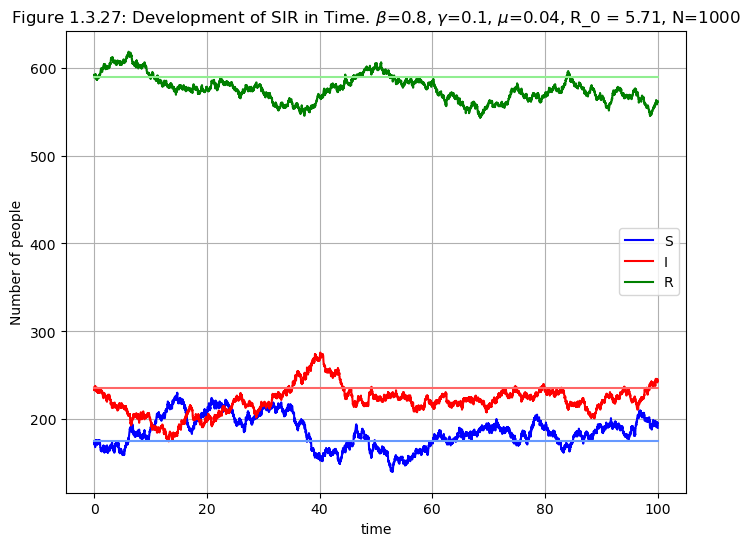

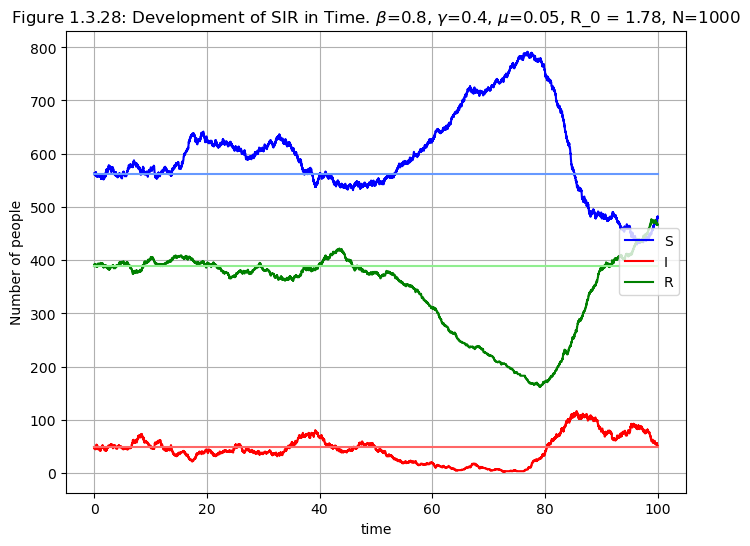

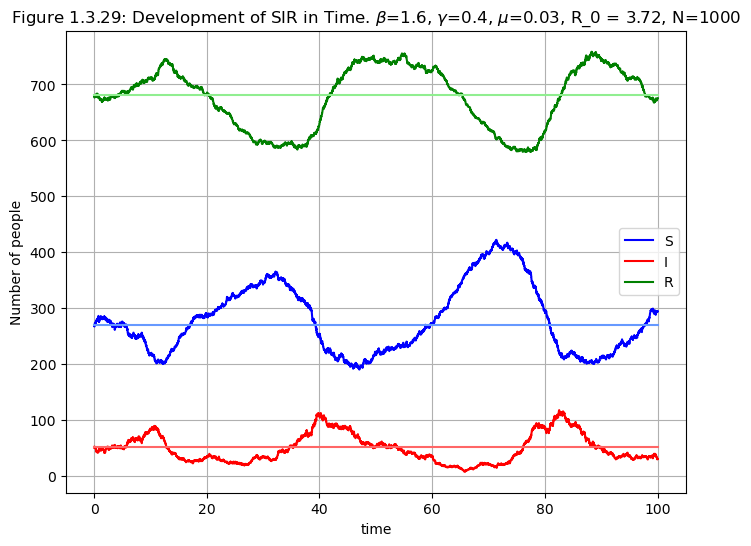

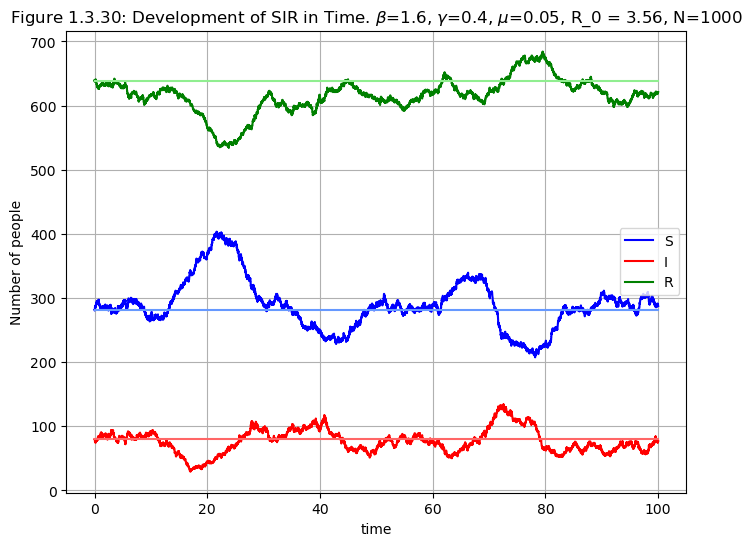

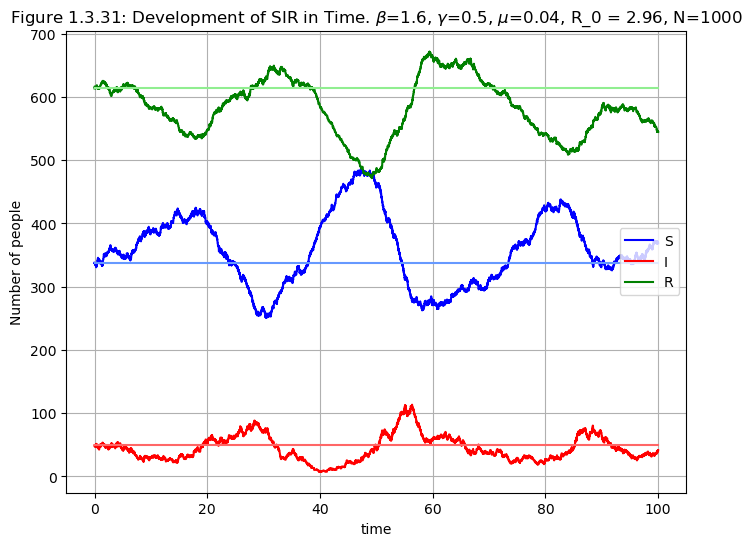

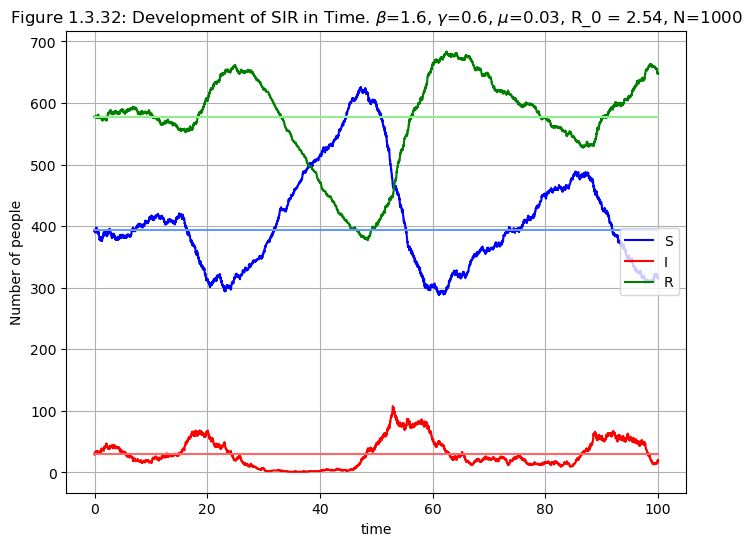

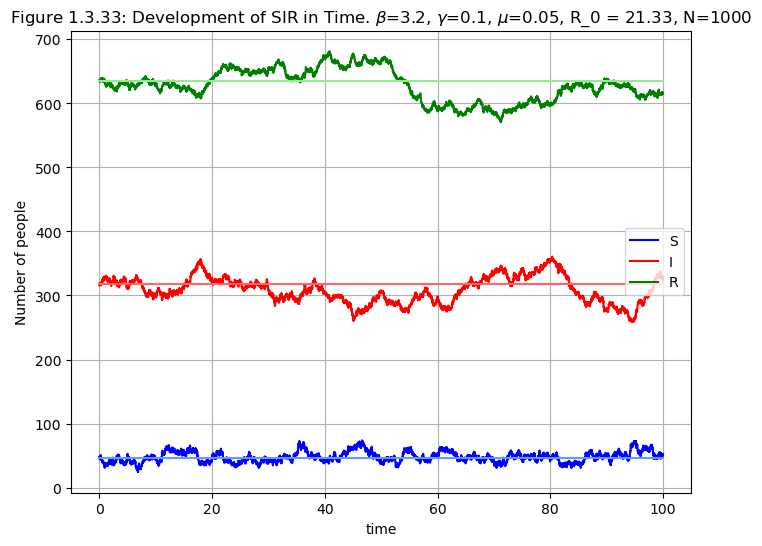

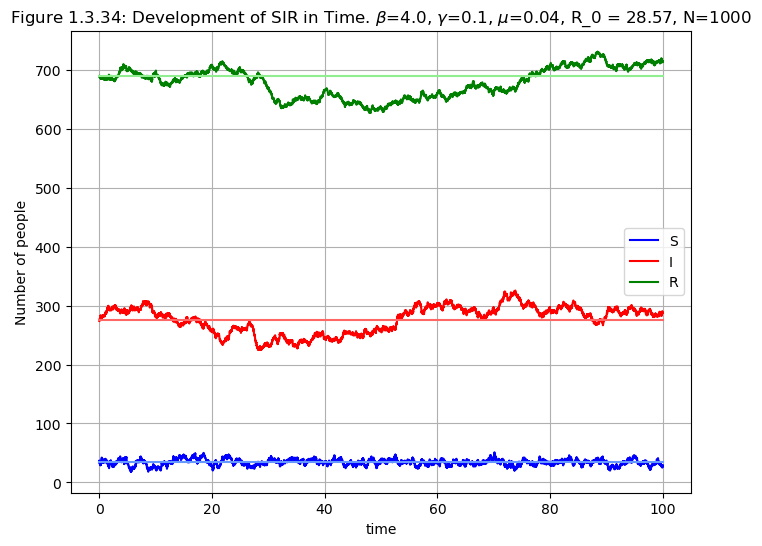

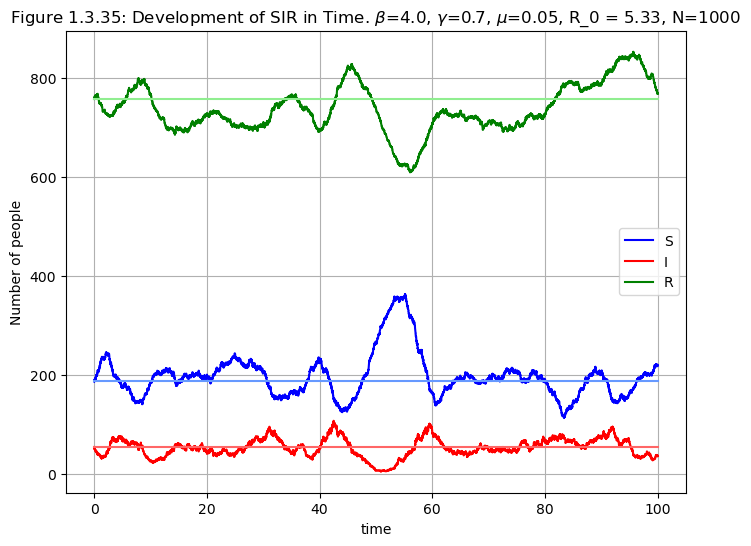

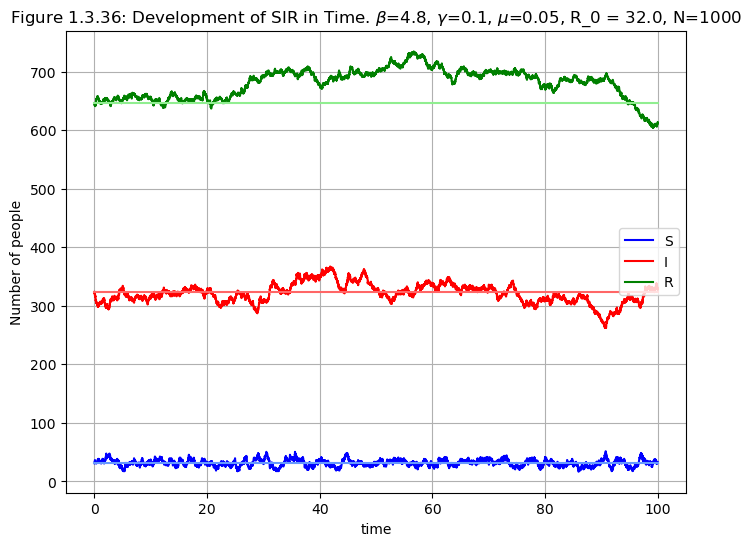

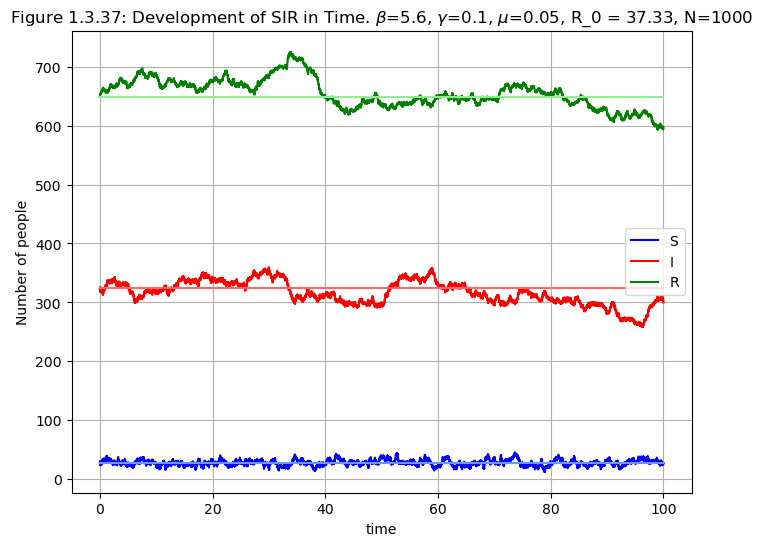

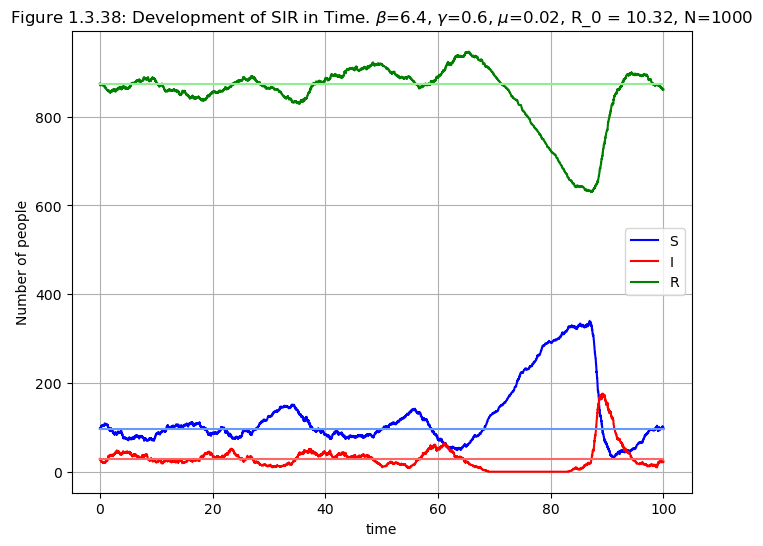

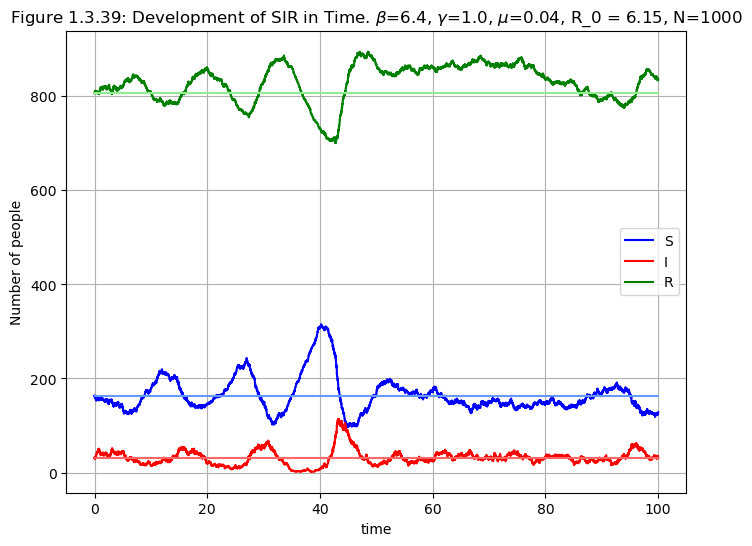

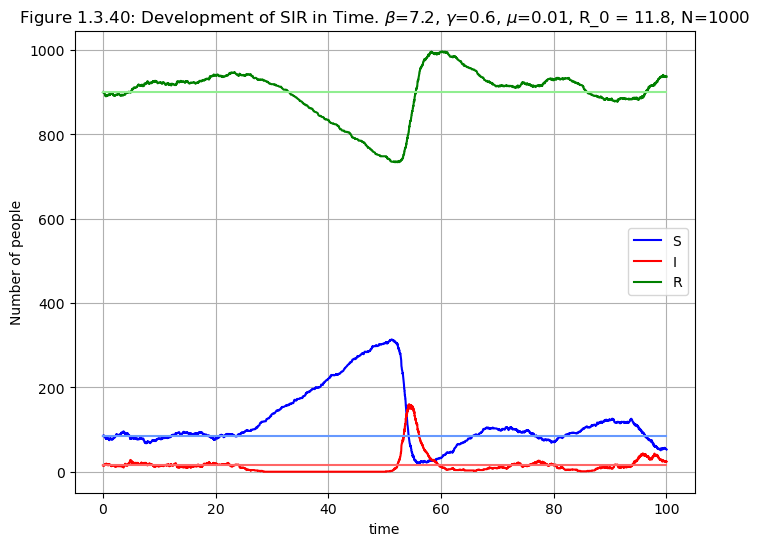

In [123]:
for i in range(10):
    for j in range(10):
        for k in range(5):
            beta_13 = 0.8*(i+1)
            gamma_13 = 0.1*(j+1)
            mu_13 = 0.01*(k+1)
            solution_13 = odeint(my_ode_11, SIRN0_13, t1, args=(beta_13, gamma_13, mu_13))    
            S_solution_13, I_solution_13, R_solution_13, N_solution_13 = solution_13.T       
            #the last value set of these variables provides us with an approximation of the equilibrium point
           
            # Gillespie's Direct Algorithm: look at box 6.3 on page 201 of the KR book. 
            # step 1: label all possible events
            events = ['births', 'transmission', 'recovery', 'death_in_S', 'death_in_I', 'death_in_R']       
            
            time = [0]
            X = [S_solution_13[-1]]
            Y = [I_solution_13[-1]]
            Z = [R_solution_13[-1]]
            extinction = False
            
            while time[-1] < t_final:
                # step 2: determine the rate at which each event occurs
                event_rates = np.array([mu_13*N, beta_13*X[-1]*Y[-1]/N, gamma_13*Y[-1], 
                                        mu_13*X[-1], mu_13*Y[-1], mu_13*Z[-1]])            
                # step 3: the rate at which any event occurs
                rate_sum = np.sum(event_rates)               
                # step 4: the time until the next event
                delta_t = -1/rate_sum * np.log(1-np.random.uniform(0,1))       
                # step 5: generate a new random number
                p = np.random.uniform(0,1) * rate_sum     
                # step 6: adjust the time-variable     
                time.append(time[-1] + delta_t)                                                  
                if 0 <= p and p <= np.sum(event_rates[:1]):                                      
                    X.append(X[-1] + 1)
                    Y.append(Y[-1])
                    Z.append(Z[-1])
                elif np.sum(event_rates[:1]) < p and p <= np.sum(event_rates[:2]):
                    Y.append(Y[-1] + 1)
                    X.append(X[-1] - 1)
                    Z.append(Z[-1])
                elif np.sum(event_rates[:2]) < p and p <= np.sum(event_rates[:3]):
                    X.append(X[-1])
                    Y.append(Y[-1] - 1)
                    Z.append(Z[-1] + 1)
                elif np.sum(event_rates[:3]) < p and p <= np.sum(event_rates[:4]):
                    X.append(X[-1] - 1)
                    Y.append(Y[-1])
                    Z.append(Z[-1])
                elif np.sum(event_rates[:4]) < p and p <= np.sum(event_rates[:5]):
                    X.append(X[-1])
                    Y.append(Y[-1] - 1)
                    Z.append(Z[-1])
                elif np.sum(event_rates[:5]) < p and p <= np.sum(event_rates[:6]):
                    X.append(X[-1])
                    Y.append(Y[-1])
                    Z.append(Z[-1] - 1)        
                if Y[-1] == 0 and Y[-2] != 0:
                    extinction = True
                    print(f'extinction at time = {time[-1]}')
            solution_13 = odeint(my_ode_11, [S_solution_13[-1],I_solution_13[-1],R_solution_13[-1],N], t, args=(beta_13, gamma_13, mu_13))
            S_solution_13, I_solution_13, R_solution_13, N_solution_13 = solution_13.T
            if max(Y) - min(Y) > 100:
                
                plt.figure(figsize=(8, 6))
                plt.plot(time, X, label='S', color= blues[0])
                plt.plot(time, Y, label='I', color= reds[0])
                plt.plot(time, Z, label='R', color= greens[0])
                plt.plot(t, S_solution_13, color= blues[1])
                plt.plot(t, I_solution_13, color= reds[1])
                plt.plot(t, R_solution_13, color= greens[1])
                
                plt.xlabel('time')
                plt.ylabel('Number of people')
                plt.title(fr'Figure 1.3.{counter}: Development of SIR in Time. $\beta$={round(beta_13,2)}, $\gamma$={round(gamma_13,2)}, $\mu$={round(mu_13,2)}, R_0 = {round(round(beta_13,2)/(round(gamma_13,2)+round(mu_13,2)),2)}, N={N}')
                plt.legend(loc='center right')
                plt.grid()
                plt.show()
                counter += 1

### Experiment 3: Extinction Process and Critical Community Size

Now evaluate the link between the behavior of extinction rate and different values of $R_0$ and population sizes. 

In [ ]:
N0 = 1000 #Size of the population
t_final = 1000
runs = 10

In [ ]:
for i in range(4): #4 iterations of i will give populations of 10^3, 5*10^3, 10^4, 5*10^4, 10^5, 5*10^5 and 10^6
    N = N0*10**i
    for j in range(10):
        counter = 0
        for k in range(runs):
            gamma_14 = 0.1
            mu_14 = 0.02
            R_0 = 1+0.1*j
            beta_14 = R_0*(gamma_14+mu_14)
            
            # Gillespie's Direct Algorithm: box 6.3 on page 201 of the KR book. 
            # step 1: label all possible events
            events = ['births', 'transmission', 'recovery', 'death_in_S', 'death_in_I', 'death_in_R']       
            time = [0]
            X = [0.8*N]
            Y = [0.2*N]
            Z = [0]
            extinction = False
            while time[-1] < t_final:
                # step 2: determine the rate at which each event occurs
                event_rates = np.array([mu_13*N, beta_13*X[-1]*Y[-1]/N, gamma_13*Y[-1], mu_13*X[-1], mu_13*Y[-1], mu_13*Z[-1]]) 
                # step 3: the rate at which any event occurs
                rate_sum = np.sum(event_rates)      
                # step 4: the time until the next event
                delta_t = -1/rate_sum * np.log(1-np.random.uniform(0,1))   
                # step 5: generate a new random number
                p = np.random.uniform(0,1) * rate_sum                                                      
                time.append(time[-1] + delta_t)                                                        
                if 0 <= p and p <= np.sum(event_rates[:1]):
                    X.append(X[-1] + 1)
                    Y.append(Y[-1])
                    Z.append(Z[-1])
                elif np.sum(event_rates[:1]) < p and p <= np.sum(event_rates[:2]):
                    Y.append(Y[-1] + 1)
                    X.append(X[-1] - 1)
                    Z.append(Z[-1])
                elif np.sum(event_rates[:2]) < p and p <= np.sum(event_rates[:3]):
                    X.append(X[-1])
                    Y.append(Y[-1] - 1)
                    Z.append(Z[-1] + 1)
                elif np.sum(event_rates[:3]) < p and p <= np.sum(event_rates[:4]):
                    X.append(X[-1] - 1)
                    Y.append(Y[-1])
                    Z.append(Z[-1])
                elif np.sum(event_rates[:4]) < p and p <= np.sum(event_rates[:5]):
                    X.append(X[-1])
                    Y.append(Y[-1] - 1)
                    Z.append(Z[-1])
                elif np.sum(event_rates[:5]) < p and p <= np.sum(event_rates[:6]):
                    X.append(X[-1])
                    Y.append(Y[-1])
                    Z.append(Z[-1] - 1)        
                if Y[-2] > 0 and Y[-1] <= 0:
                    extinction = True
                    counter += 1
                    # print(f'extinction at time = {time[-1]} with R_0={R_0} and N={N}')
        print(f'With R_0={round(R_0,2)} and N={N}, {counter} out of {runs} runs resulted in extinction within {t_final} days.')

## Problem 2:  Spatial Models - Networks

Start by reading the SocioPatterns data file 

In [124]:
path= "/Users/aleksandar/Desktop/Computational Science MSc/Introduction to Computational Science/Assignements/assignment_2_2023_oct_5/"
os.chdir(path)
# Hello

In [125]:
# the path to the folder containing the csv file
folder_path = 'data/'

# the name of the csv file you want to read
file_name = 'transmission_network.csv'

# combine the folder path and file name to create the file path
file_path = folder_path + file_name

# read the csv file into a data frame
try:
    df = pd.read_csv(file_path, sep = ";")
    print(df.head())
except FileNotFoundError:
    print(f"The file '{file_name}' was not found in the folder '{folder_path}'.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

   Unnamed: 0  1467  1591  1513  1568  1562  1524  1771  1428  1600  ...  \
0        1467     0    17     0     0     0     0     0     0     0  ...   
1        1591    17     0     0     0     0     0     0     0     0  ...   
2        1513     0     0     0     0     0     0     0     0     0  ...   
3        1568     0     0     0     0     0    10     0     0     0  ...   
4        1562     0     0     0     0     0     0     0     0     0  ...   

   1768  1715  1663  1708  1658  1876  1913  1883  1870  1446  
0     0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0     0     0     0  
2     0     0     0     0     0     0     0     0     0     0  
3     0     0     0     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0     0     0     0  

[5 rows x 375 columns]


In [126]:
df = df.rename(columns={df.columns[0]:'nodes'})
display(df)

,nodes,1467,1591,1513,1568,1562,1524,1771,1428,1600,...,1768,1715,1663,1708,1658,1876,1913,1883,1870,1446
0,1467,0,17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1591,17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1513,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1568,0,0,0,0,0,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1562,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1876,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
370,1913,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
371,1883,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372,1870,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


the network adjacency matrix is given with the 'nodes' column and the other col names giving the opposite node indicatiors

Following the guidance in the assignment, we disregard the weights and assume all contacts involve equal length of contact and hence equal chance of transmission. Hence, we convert the adjacency matrix above into the one where all weights are equal to 1. 

In [127]:
# change all non-zero values from the second column onwards to 1
df.iloc[:, 1:] = (df.iloc[:, 1:] != 0).astype(int)

display(df)

,nodes,1467,1591,1513,1568,1562,1524,1771,1428,1600,...,1768,1715,1663,1708,1658,1876,1913,1883,1870,1446
0,1467,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1591,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1513,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1568,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1562,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1876,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
370,1913,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
371,1883,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372,1870,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Problem 2.1: 

Implement SIR disease spread on the sociopattern network. Think about your experimental design and which parameters of the model you will want to vary. Design code that will allow you run multiple simulations while varying the disease parameter

### Set Up

Test create an ER graph object

In [128]:
g_er = nx.erdos_renyi_graph(1000, 0.1)

Create a graph object using the SocioPatterns adjacency matrix

In [129]:
# create a graph object
g = nx.Graph()

# extract node names from the first column of the dataframe
nodes = df['nodes'].tolist()
# add nodes to the graph
g.add_nodes_from(nodes)

In [130]:
num_nodes = g.number_of_nodes()
print(num_nodes)

374


In [131]:
print(nodes)
print(len(nodes))

[1467, 1591, 1513, 1568, 1562, 1524, 1771, 1428, 1600, 1523, 1525, 1529, 1544, 1519, 1583, 1510, 1549, 1553, 1606, 1622, 1599, 1560, 1602, 1631, 1573, 1537, 1531, 1539, 1604, 1543, 1526, 1582, 1551, 1269, 1463, 1628, 1552, 1514, 1547, 1504, 1601, 1629, 1616, 1518, 1691, 1545, 1580, 1569, 1520, 1742, 1430, 1453, 1563, 1434, 1448, 1487, 1626, 1512, 1527, 1592, 1437, 1542, 1461, 1578, 1521, 1593, 1598, 1655, 1436, 1724, 1469, 1489, 1853, 1915, 1451, 1459, 1441, 1789, 1920, 1538, 1874, 1574, 1532, 1617, 1779, 1522, 1774, 1825, 1903, 1791, 1857, 1678, 1449, 1716, 1808, 1503, 1839, 1641, 1773, 1458, 1546, 1468, 1558, 1871, 1572, 1767, 1872, 1879, 1613, 1444, 1554, 1623, 1452, 1858, 1634, 1497, 1500, 1511, 1556, 1590, 1530, 1559, 1596, 1464, 1619, 1904, 1517, 1557, 1460, 1499, 1541, 1555, 1533, 1840, 1612, 1465, 1579, 1426, 1470, 1466, 1608, 1528, 1650, 1457, 1668, 1762, 1743, 1501, 1587, 1535, 1431, 1438, 1516, 1847, 1507, 1425, 1433, 1652, 1900, 1747, 1917, 1548, 1495, 1493, 1790, 1912, 173

In [132]:
# iterate through the dataframe and add edges
for index, row in df.iterrows():
    source_node = row['nodes']
    for col_name, edge_value in row.items():
        if col_name != 'nodes' and edge_value != 0:
            target_node = int(col_name)
            g.add_edge(source_node, target_node)

In [133]:
nodes_list = list(g.nodes())
print(nodes_list)

[1467, 1591, 1513, 1568, 1562, 1524, 1771, 1428, 1600, 1523, 1525, 1529, 1544, 1519, 1583, 1510, 1549, 1553, 1606, 1622, 1599, 1560, 1602, 1631, 1573, 1537, 1531, 1539, 1604, 1543, 1526, 1582, 1551, 1269, 1463, 1628, 1552, 1514, 1547, 1504, 1601, 1629, 1616, 1518, 1691, 1545, 1580, 1569, 1520, 1742, 1430, 1453, 1563, 1434, 1448, 1487, 1626, 1512, 1527, 1592, 1437, 1542, 1461, 1578, 1521, 1593, 1598, 1655, 1436, 1724, 1469, 1489, 1853, 1915, 1451, 1459, 1441, 1789, 1920, 1538, 1874, 1574, 1532, 1617, 1779, 1522, 1774, 1825, 1903, 1791, 1857, 1678, 1449, 1716, 1808, 1503, 1839, 1641, 1773, 1458, 1546, 1468, 1558, 1871, 1572, 1767, 1872, 1879, 1613, 1444, 1554, 1623, 1452, 1858, 1634, 1497, 1500, 1511, 1556, 1590, 1530, 1559, 1596, 1464, 1619, 1904, 1517, 1557, 1460, 1499, 1541, 1555, 1533, 1840, 1612, 1465, 1579, 1426, 1470, 1466, 1608, 1528, 1650, 1457, 1668, 1762, 1743, 1501, 1587, 1535, 1431, 1438, 1516, 1847, 1507, 1425, 1433, 1652, 1900, 1747, 1917, 1548, 1495, 1493, 1790, 1912, 173

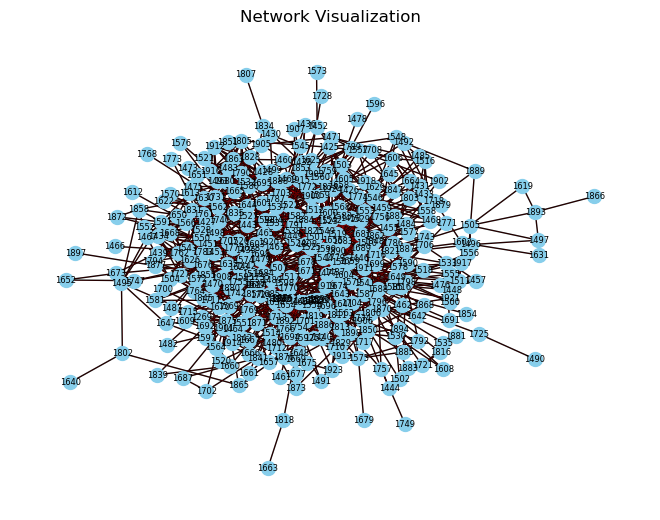

In [134]:
# create a layout for the nodes
pos = nx.kamada_kawai_layout(g)

# draw the nodes and edges
nx.draw(g, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edges(g, pos, edge_color='red', width=0.1)

# display the graph
plt.axis('off')
plt.title("Network Visualization")
plt.show()

add a relabled version of the graph - where existing nodes are labled in an order

In [135]:
mapping = {node: i for i, node in enumerate(g.nodes())}
g_re = nx.relabel_nodes(g, mapping)

In [136]:
print(g_re.nodes())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

### Model Selection and Configuration

Set up SIR model configurations using the code on the NDlib reference page

Import epidemics from ndlib and set up the SIR model object

In [137]:
model = ep.SIRModel(g_re)

Use json to obtain parameters of the model

In [138]:
import json

In [139]:
print(json.dumps(model.parameters, indent=2))

{
  "model": {
    "beta": {
      "descr": "Infection rate",
      "range": [
        0,
        1
      ],
      "optional": false
    },
    "gamma": {
      "descr": "Recovery rate",
      "range": [
        0,
        1
      ],
      "optional": false
    },
    "tp_rate": {
      "descr": "Whether if the infection rate depends on the number of infected neighbors",
      "range": [
        0,
        1
      ],
      "optional": true,
      "default": 1
    }
  },
  "nodes": {},
  "edges": {}
}


Display available model statuses

In [140]:
model.available_statuses

{'Susceptible': 0, 'Infected': 1, 'Removed': 2}

Specify a model configuration by setting model parameter values

In [141]:
import ndlib.models.ModelConfig as mc

In [142]:
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.02) #infection rate
cfg.add_model_parameter('gamma', 0.01) #recovery rate 
# + 
cfg.add_model_parameter("percentage_infected", 0.01)
model.set_initial_status(cfg)

As described in the reference notebook, NDlib models diffusive phenomena as discrete-time, agent-based processes, where during every iteration all nodes are evaluated and, their statuses are updated accoridng to the model rules. 

We use iterations to generate model outcome instances, across all nodes. 

In [143]:
iterations = model.iteration_bunch(200, node_status = True)

We use build_trends to transform iterations into diffusion trends

In [144]:
trends = model.build_trends(iterations)

In [145]:
print(type(trends[0]['trends']))

<class 'dict'>


In [146]:
print(trends[0]['trends'].keys())

dict_keys(['node_count', 'status_delta'])


#### Visualise using DiffusionTrend and DiffusionPrevalence 

Diffusion trend in the SIR spread on the network

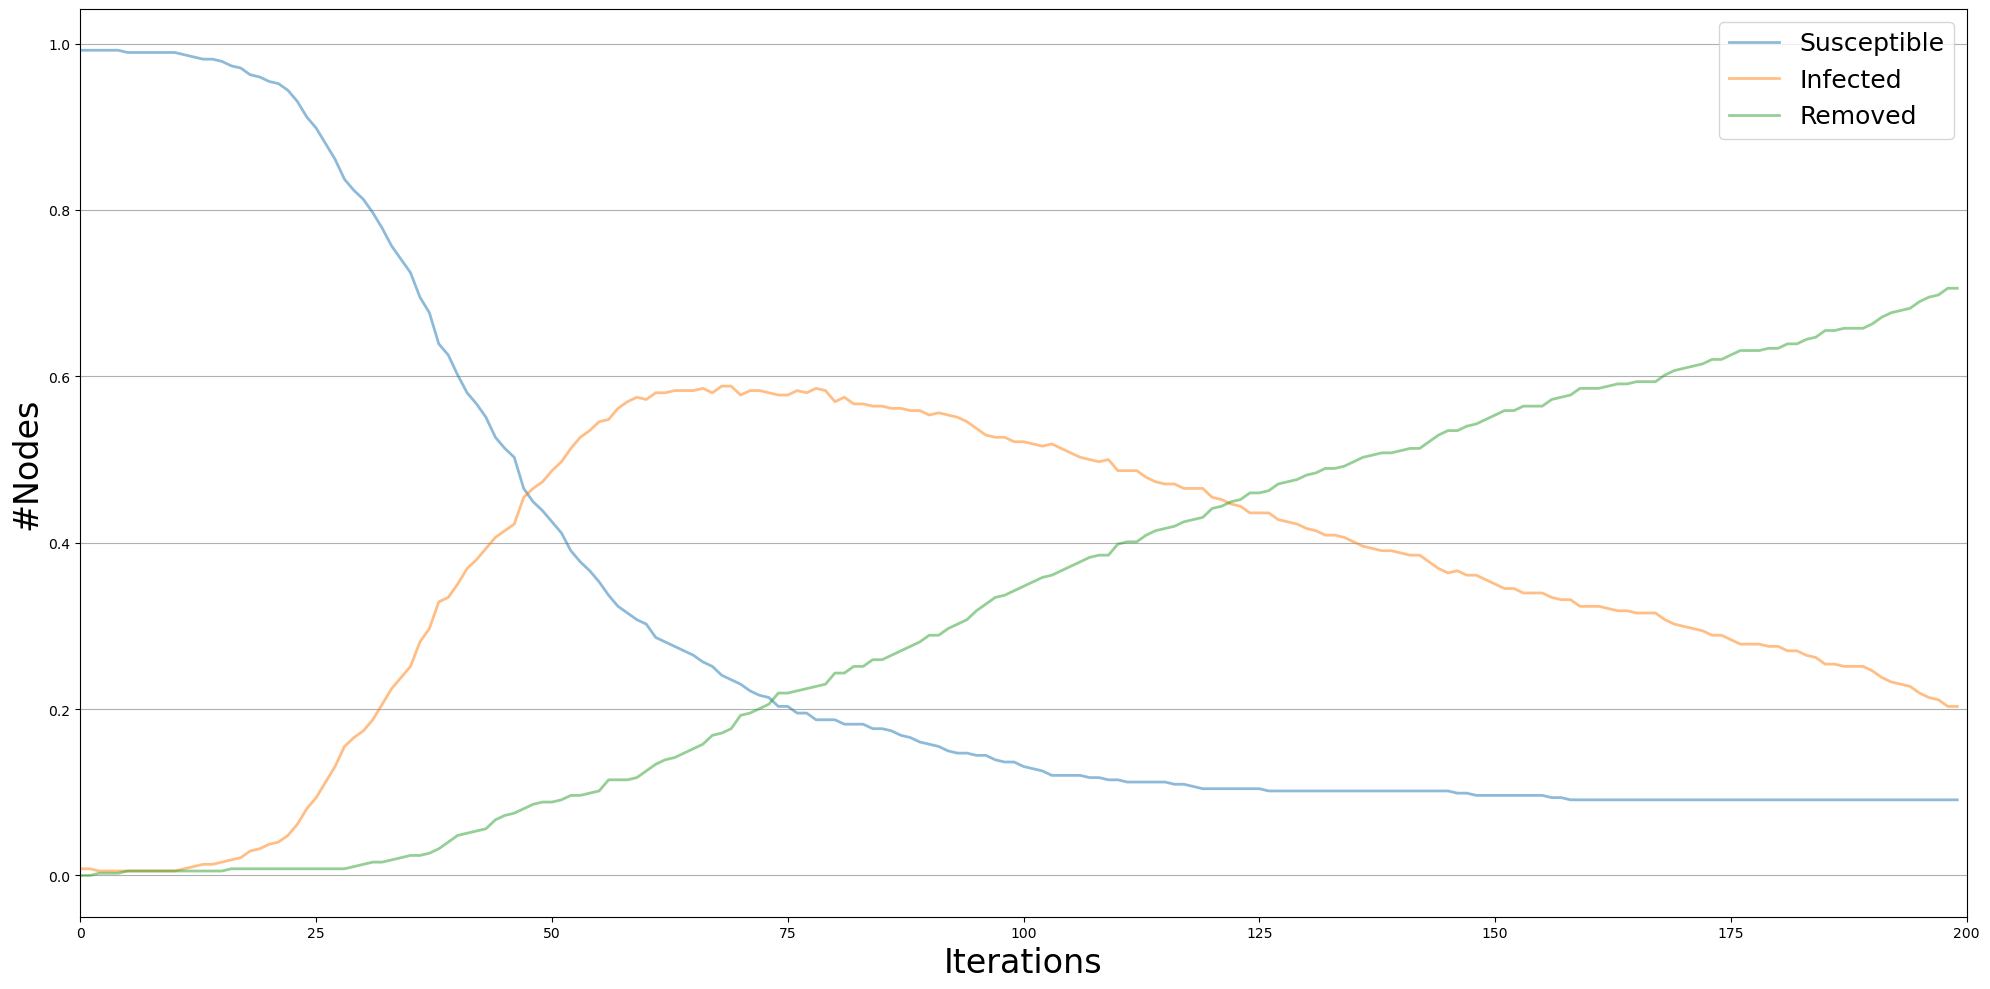

In [147]:
%matplotlib inline
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

viz = DiffusionTrend(model, trends)
viz.plot() 

# assuming the last created figure and axes are the ones from DiffusionTrend
#fig, ax = plt.gcf(), plt.gca()  # Get current figure and axes

# customize
#ax.set_title(fr'Figure: SIR Spread on the SocioPatterns Network')
#ax.set_xlabel('Iterations')
#ax.set_ylabel('Fraction of Nodes')
#ax.legend()
#ax.grid()

#plt.show()
#counter += 1


Diffusion prevalence in the SIR spread on the network

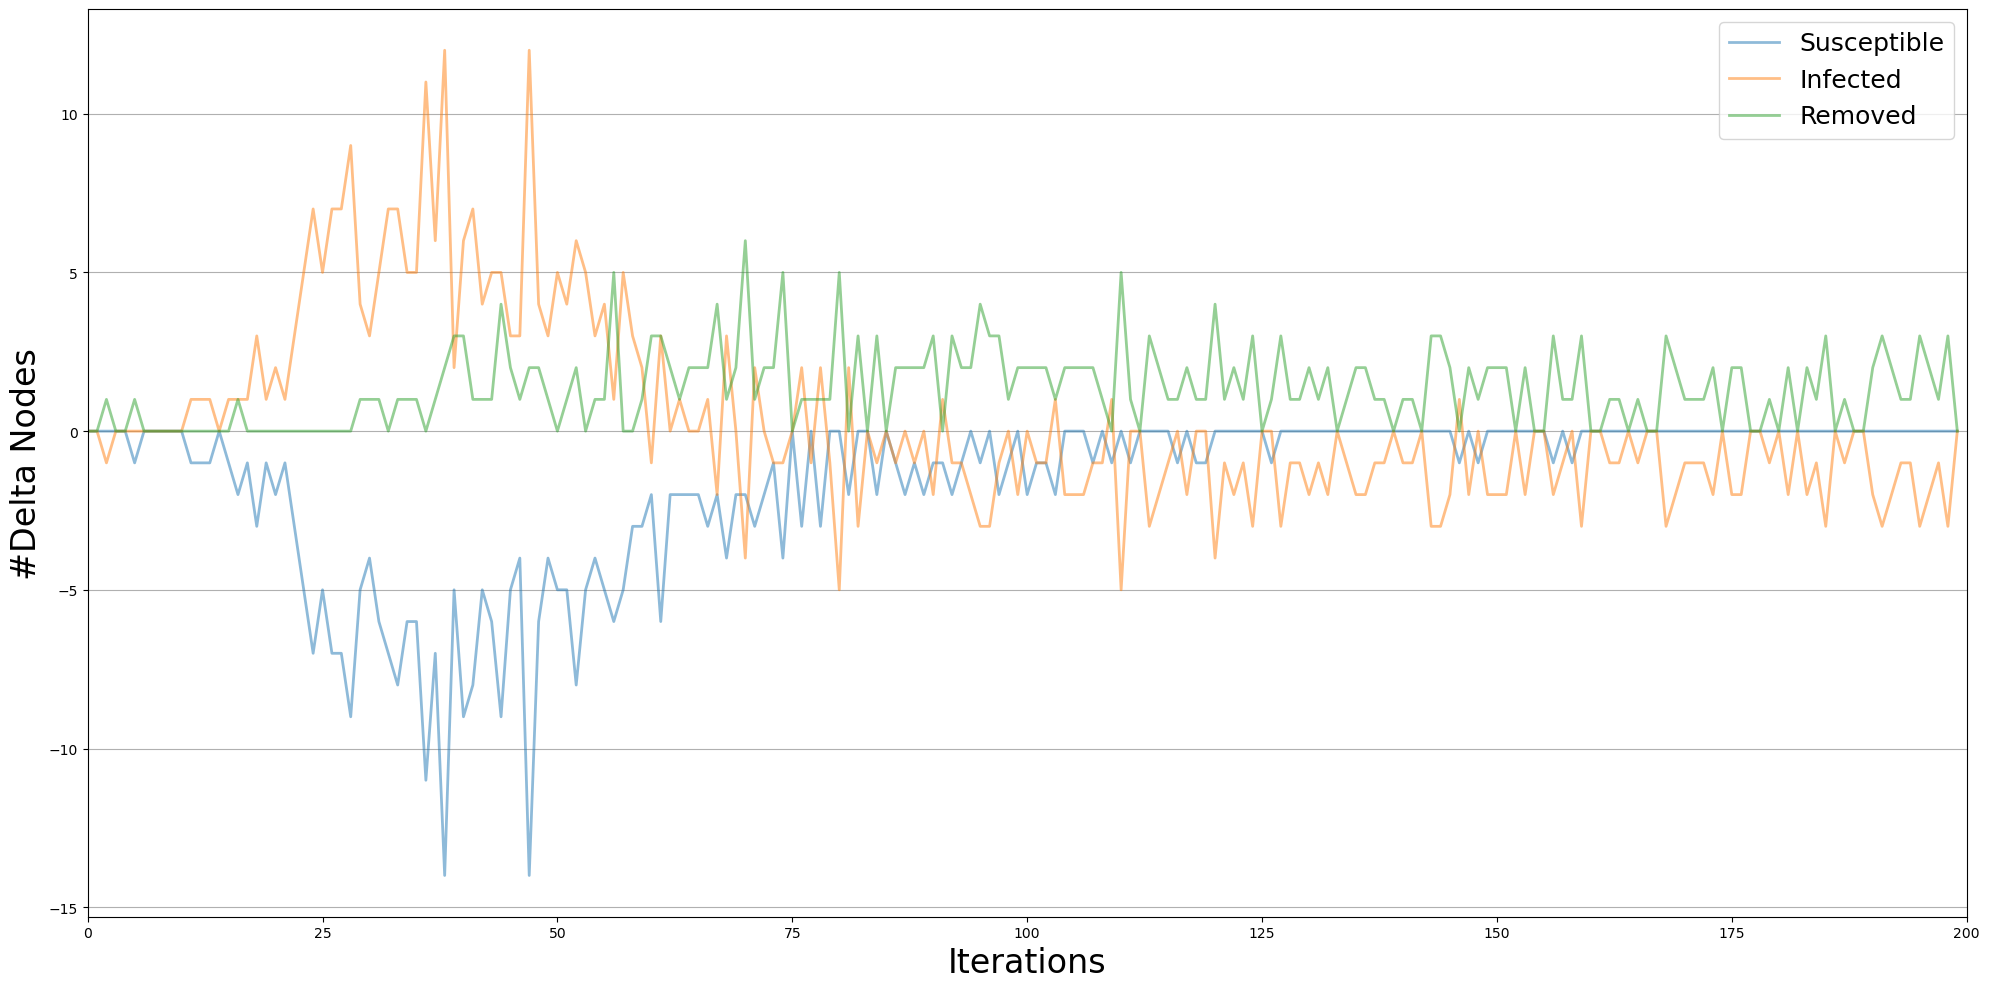

In [148]:
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
viz = DiffusionPrevalence (model, trends)
viz.plot()

Set the parameter range values

In [149]:
beta_values = np.linspace(0.1, 3, 101)
gamma_values = np.linspace(0.01, 1, 101)
percentage_infected = 0.01

In [150]:
r0_values = []

for beta in beta_values: 
    for gamma in gamma_values: 
        r0 = beta/gamma
        r0_values.append(r0)

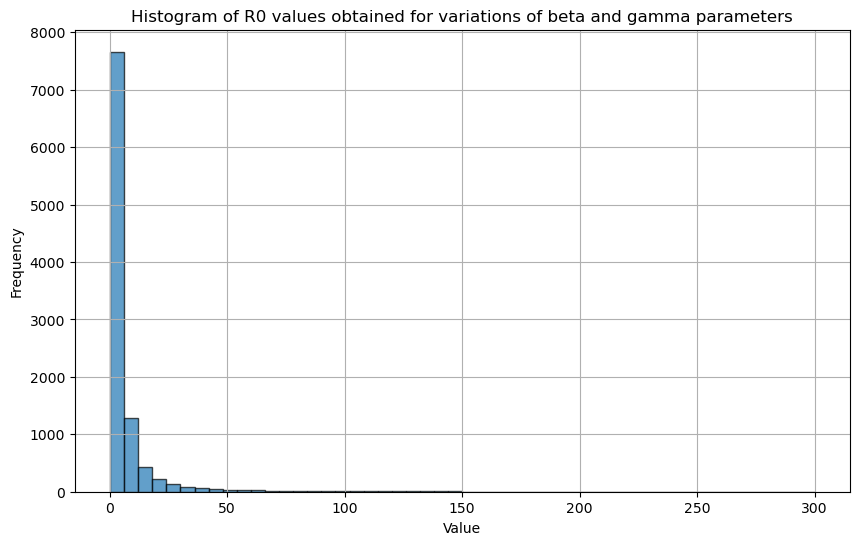

In [151]:
# R0 histogram
plt.figure(figsize=(10, 6))

plt.hist(r0_values, bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of R0 values obtained for variations of beta and gamma parameters')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Initiate variables to store results of each run in

In [152]:
all_I = []
avg_S = []
avg_I = []
avg_R = []

generate model outcomes (101x101)

In [153]:
for beta in beta_values:
    for gamma in gamma_values:
        for node in g_re.nodes():
            model.status[node] = 0  # 0 stands for susceptible
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', beta)
        cfg.add_model_parameter('gamma', gamma)
        
        number_of_initial_infected = int(len(g_re.nodes()) * percentage_infected)
        if number_of_initial_infected >= len(g_re.nodes()):
            number_of_initial_infected = len(g_re.nodes()) - 1
            percentage_infected = number_of_initial_infected / len(g_re.nodes())
            print(percentage_infected)
        cfg.add_model_parameter("percentage_infected", percentage_infected)
        model.set_initial_status(cfg)

        iterations = model.iteration_bunch(200, node_status=True)
        trends = model.build_trends(iterations)

        # Extract values based on updated structure
        node_counts = trends[0]['trends']['node_count']
        S = node_counts[0]
        I = node_counts[1]
        R = node_counts[2]
        
        # Storing all I for the plot of all realizations
        all_I.append(I)

        # Update the sums for averages
        if not avg_S:
            avg_S = S
            avg_I = I
            avg_R = R
        else:
            avg_S = [s + s_cur for s, s_cur in zip(avg_S, S)]
            avg_I = [i + i_cur for i, i_cur in zip(avg_I, I)]
            avg_R = [r + r_cur for r, r_cur in zip(avg_R, R)]           

In [154]:
# get the actual averages and standard deviations
total_runs = len(beta_values) * len(gamma_values)
avg_S = [s/total_runs for s in avg_S]
avg_I = [i/total_runs for i in avg_I]
avg_R = [r/total_runs for r in avg_R]

std_I = np.std(all_I, axis=0)

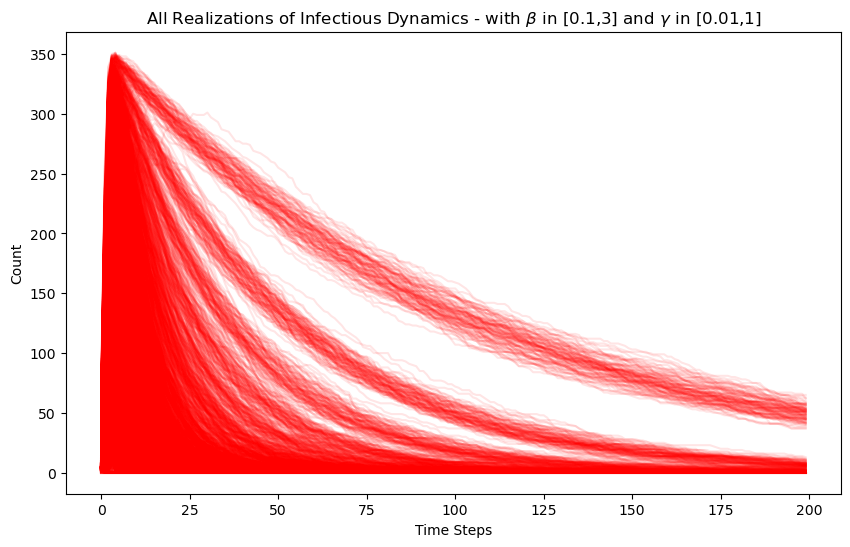

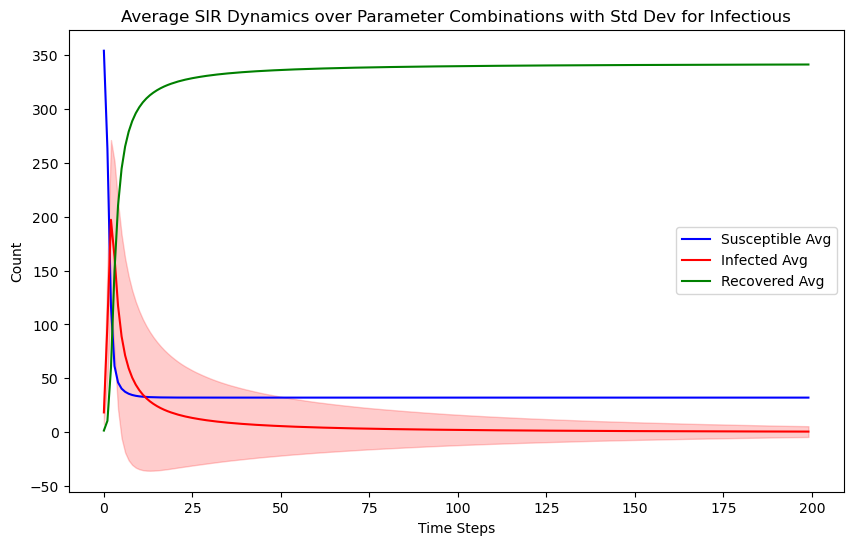

In [155]:
# Plot of all the realizations
plt.figure(figsize=(10, 6))
for I in all_I:
    plt.plot(I, color='red', alpha=0.1)  # alpha for transparency
plt.title(r'All Realizations of Infectious Dynamics - with $\beta$ in [0.1,3] and $\gamma$ in [0.01,1]')
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.show()

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(avg_S, label="Susceptible Avg", color='blue')
plt.fill_between(range(len(avg_I)), 
                 [i - s for i, s in zip(avg_I, std_I)], 
                 [i + s for i, s in zip(avg_I, std_I)], 
                 color='red', alpha=0.2)
plt.plot(avg_I, label="Infected Avg", color='red')
plt.plot(avg_R, label="Recovered Avg", color='green')
plt.title("Average SIR Dynamics over Parameter Combinations with Std Dev for Infectious")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()

## Problem 2.2

Using NetworkX generate multiple model networks with similar characteristics, again think about the parameters associated with each network generator (e.g., number of nodes, connection probability,etc). Pick some network statistics (e.g., centrality measures, degree distributions, etc.) that are interesting to measure in terms of spreading on the network. You should generate multiple instances of each network type and then plot the network statistics (you chose) and discuss how these statistic differ between network types and for different parameter settings. You will use these generated networks in your SIR experiments in the next part.

In [157]:
### Network Statistics to Calculate for Various Network Models

Most commonly used network statistics:

1. **Number of Nodes and Edges**: 
   - The most basic characteristics that tell about the size of the network.

2. **Average Degree**:
   - The average number of connections each node in the network has.
  
3. **Degree Distribution**:
   - Shows how nodes in the network are connected on average. It often helps to classify networks into types (e.g., scale-free, random).

4. **Clustering Coefficient**:
   - Measures the degree to which nodes in a graph tend to cluster together. It signifies the presence of tightly-knit groups in a network.

5. **Average Path Length**:
   - The average number of steps along the shortest paths for all possible pairs of network nodes. It gives a measure of the network's efficiency.

6. **Diameter**:
   - The longest of all the calculated shortest paths in the network. It gives the maximum network distance.

7. **Centrality Measures**:
   - Indicators that identify the most important nodes in a network. Common measures include:
     - **Degree Centrality**: Number of links held by each node.
     - **Betweenness Centrality**: Number of times a node acts as a bridge (or "broker") between two other nodes.
     - **Eigenvector Centrality**: Measures a node's influence based on the number of links it has to other influential nodes.
  
8. **Density**:
   - The ratio of the number of edges in the network to the number of possible edges. It gives a measure of how closely knit the network is.

9. **Modularity**:
   - A measure of the structure of the network, used to detect communities or clusters in the network. A high modularity indicates that the network is organized into communities with dense connections within communities and sparser connections between communities. (computationally expensive)  

10. **Assortativity Coefficient**:
   - Measures the similarity of connections in the network concerning the node degree. Positive assortativity indicates that nodes with a high degree tend to connect with other high-degree nodes, while negative values indicate the opposite.

These statistics provide various insights into the structure and properties of networks, and their relevance can vary depending on the context and the specific research questions at hand.

In [158]:
from scipy.stats import skew, kurtosis

In [159]:
# compute the commonly used network statistics
def compute_network_statistics(G):
    stats = {}

    # 1. number of nodes and edges
    stats['num_nodes'] = G.number_of_nodes()
    stats['num_edges'] = G.number_of_edges()

    # 2. average degree
    degrees = [d for n, d in G.degree()]
    stats['average_degree'] = np.mean(degrees)

    # 3. average clustering coefficient
    stats['avg_clustering_coefficient'] = nx.average_clustering(G)

    # 4. average path length
    if nx.is_connected(G):
        stats['avg_path_length'] = nx.average_shortest_path_length(G)
    else:
        stats['avg_path_length'] = None

    # 5. diameter
    if nx.is_connected(G): # check if the nework is indeed connected 
        stats['diameter'] = nx.diameter(G)
    else:
        stats['diameter'] = None

    # 6. centrality measures
    degree_centrality = nx.degree_centrality(G)
    stats['avg_degree_centrality'] = np.mean(list(degree_centrality.values()))

    betweenness_centrality = nx.betweenness_centrality(G)
    stats['avg_betweenness_centrality'] = np.mean(list(betweenness_centrality.values()))

    # 7. Density
    # stats['density'] = nx.density(G)

    # 8. Assortativity Coefficient
    # stats['assortativity_coefficient'] = nx.degree_assortativity_coefficient(G)
    
    return stats

### 2.2.1. Erdos-Reyni (ER) Networks

There are two ways to generate an ER network: 

- by prespecifying the number of randomly generated edges for a given set of nodes n: G(n,M) 
- by prespecifying the probability p with which any given edge between two nodes (out of n) can be included in the network: G(n,p) 

The latter is more common. 

Generate ER networks

In [160]:
node_range = np.linspace(100, 1000, 11)
p_values = np.linspace(0.01, 1, 11)

results = []

for nodes in node_range:
    nodes = int(nodes)
    for p in p_values:
        G = nx.erdos_renyi_graph(nodes, p)
        stats = compute_network_statistics(G)
        results.append(stats)

# convert to dataframe
df_ER = pd.DataFrame(results)

In [161]:
custom_summary = df_ER.groupby(df_ER.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

num_edges                                                       \
                    mean            std    median   min     max           var   
num_nodes                                                                       
100          2486.636364    1624.820499    2497.0    53    4950  2.640042e+06   
190          9039.181818    5895.003474    9075.0   177   17955  3.475107e+07   
280         19749.909091   12833.984545   19799.0   400   39060  1.647112e+08   
370         34467.727273   22413.718822   34358.0   687   68265  5.023748e+08   
460         53268.090909   34641.433214   53012.0  1081  105570  1.200029e+09   
550         76285.909091   49579.348801   75971.0  1511  150975  2.458112e+09   
640        103230.181818   67127.791113  103199.0  2128  204480  4.506140e+09   
730        134393.272727   87322.722989  134522.0  2666  266085  7.625258e+09   
820        169693.454545  110314.165017  169644.0  3411  335790  1.216922e+10   
910        208787.090909  135749.218115  208930.0  4189  413595  1.842785e+10   
1000       252213.454545  164096.422753  252181.0  4995  499500  2.692764e+10   

          average_degree                                    ...  \
                    mean         std      median       min  ...   
num_nodes                                                   ...   
100            49.732727   32.496410   49.940000  1.060000  ...   
190            95.149282   62.052668   95.526316  1.863158  ...   
280           141.070779   91.671318  141.421429  2.857143  ...   
370           186.312039  121.155237  185.718919  3.713514  ...   
460           231.600395  150.614927  230.486957  4.700000  ...   
550           277.403306  180.288541  276.258182  5.494545  ...   
640           322.594318  209.774347  322.496875  6.650000  ...   
730           368.200747  239.240337  368.553425  7.304110  ...   
820           413.886475  269.058939  413.765854  8.319512  ...   
910           458.872727  298.349930  459.186813  9.206593  ...   
1000          504.426909  328.192846  504.362000  9.990000  ...   

          avg_degree_centrality                           \
                         median       min  max       var   
num_nodes                                                  
100                    0.504444  0.010707  1.0  0.107746   
190                    0.505430  0.009858  1.0  0.107795   
280                    0.506887  0.010241  1.0  0.107959   
370                    0.503303  0.010064  1.0  0.107803   
460                    0.502150  0.010240  1.0  0.107674   
550                    0.503203  0.010008  1.0  0.107843   
640                    0.504690  0.010407  1.0  0.107771   
730                    0.505560  0.010019  1.0  0.107700   
820                    0.505209  0.010158  1.0  0.107926   
910                    0.505156  0.010128  1.0  0.107727   
1000                   0.504867  0.010000  1.0  0.107926   

          avg_betweenness_centrality                                     \
                                mean       std    median  min       max   
num_nodes                                                                 
100                         0.004919  0.003530  0.004993  0.0  0.012420   
190                         0.004045  0.005569  0.002631  0.0  0.020117   
280                         0.002654  0.003610  0.001774  0.0  0.013076   
370                         0.001990  0.002689  0.001350  0.0  0.009751   
460                         0.001496  0.001839  0.001087  0.0  0.006716   
550                         0.001216  0.001436  0.000907  0.0  0.005253   
640                         0.001007  0.001115  0.000776  0.0  0.004089   
730                         0.000873  0.000950  0.000679  0.0  0.003483   
820                         0.000762  0.000802  0.000605  0.0  0.002941   
910                         0.000678  0.000696  0.000545  0.0  0.002551   
1000                        0.000612  0.000617  0.000496  0.0  0.002263   

                         
                    var

### 2.2.2. Watts-Strogatz (WS) Networks

The Watts-Strogatz (WS) model is a model for generating random graphs with small-world properties, such as a short average path length and high clustering. It was introduced by Duncan Watts and Steven Strogatz in their 1998 paper to explain the small-world phenomenon observed in many real-world networks.

The model requires three primary parameters:

1. N: number of nodes in the network.
2. k: Each node is connected to \( k \) nearest neighbors in a ring topology. \( k \) is an even integer representing the degree of regular lattice nodes before rewiring - defining the initial structure of the network.
3. p: The probability of rewiring each edge to a random node. \( p = 0 \) represents a ring lattice, and \( p = 1 \) means all edges are rewired, resulting in a random network.

The network model is generated in the following steps:

1. start with a regular ring lattice: a network of \( N \) nodes in which each node is connected to \( k \) nearest neighbors.
2. for every node, take each edge and rewire it with probability \( p \). Rewiring means changing one of the nodes the edge is connected to, without loops (edges connecting a node to itself) or duplicate edges (multiple edges connecting the same pair of nodes).

The resulting network will have small-world properties for certain ranges of \( p \), with a short average path length like a random graph but a much higher clustering coefficient.

In [172]:
node_range = np.linspace(100, 1000, 10) 
k = np.linspace(1,10,10)
p_values = np.linspace(0.01, 1, 10)

results = []

for nodes in node_range:
    nodes = int(nodes)
    for k_i in k:
        k_i = int(k_i+1)
        for p in p_values:
            #print(nodes, k_i, p)
            G = nx.watts_strogatz_graph(nodes, k_i, p)
            stats = compute_network_statistics(G)
            results.append(stats)

# convert to dataframe
df_WS = pd.DataFrame(results)

In [173]:
node_range

array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000.])

In [174]:
custom_summary = df_WS.groupby(df_WS.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

num_edges                                                 \
               mean          std  median   min   max           var   
num_nodes                                                            
100           300.0   142.133811   300.0   100   500  2.020202e+04   
200           600.0   284.267622   600.0   200  1000  8.080808e+04   
300           900.0   426.401433   900.0   300  1500  1.818182e+05   
400          1200.0   568.535244  1200.0   400  2000  3.232323e+05   
500          1500.0   710.669055  1500.0   500  2500  5.050505e+05   
600          1800.0   852.802865  1800.0   600  3000  7.272727e+05   
700          2100.0   994.936676  2100.0   700  3500  9.898990e+05   
800          2400.0  1137.070487  2400.0   800  4000  1.292929e+06   
900          2700.0  1279.204298  2700.0   900  4500  1.636364e+06   
1000         3000.0  1421.338109  3000.0  1000  5000  2.020202e+06   

          average_degree                        ... avg_degree_centrality  \
                    mean       std median  min  ...                median   
num_nodes                                       ...                         
100                  6.0  2.842676    6.0  2.0  ...              0.060606   
200                  6.0  2.842676    6.0  2.0  ...              0.030151   
300                  6.0  2.842676    6.0  2.0  ...              0.020067   
400                  6.0  2.842676    6.0  2.0  ...              0.015038   
500                  6.0  2.842676    6.0  2.0  ...              0.012024   
600                  6.0  2.842676    6.0  2.0  ...              0.010017   
700                  6.0  2.842676    6.0  2.0  ...              0.008584   
800                  6.0  2.842676    6.0  2.0  ...              0.007509   
900                  6.0  2.842676    6.0  2.0  ...              0.006674   
1000                 6.0  2.842676    6.0  2.0  ...              0.006006   

                                        avg_betweenness_centrality            \
                min       max       var                       mean       std   
num_nodes                                                                      
100        0.020202  0.101010  0.000824                   0.038579  0.042521   
200        0.010050  0.050251  0.000204                   0.027104  0.038521   
300        0.006689  0.033445  0.000090                   0.024979  0.042364   
400        0.005013  0.025063  0.000051                   0.020400  0.037341   
500        0.004008  0.020040  0.000032                   0.018084  0.038694   
600        0.003339  0.016694  0.000023                   0.015088  0.030616   
700        0.002861  0.014306  0.000017                   0.013021  0.025058   
800        0.002503  0.012516  0.000013                   0.011747  0.019015   
900        0.002225  0.011123  0.000010                   0.012346  0.022454   
1000       0.002002  0.010010  0.000008                   0.013664  0.032714   

                                                   
             median       min       max       var  
num_nodes                                          
100        0.020357  0.012408  0.247475  0.001808  
200        0.012927  0.007787  0.251367  0.001484  
300        0.009728  0.005737  0.305460  0.001795  
400        0.007948  0.004607  0.289137  0.001394  
500        0.006695  0.003894  0.330332  0.001497  
600        0.005921  0.003379  0.221482  0.000937  
700        0.005102  0.003002  0.220200  0.000628  
800        0.004703  0.002709  0.133718  0.000362  
900        0.004271  0.002467  0.152740  0.000504  
1000       0.003938  0.002268  0.254454  0.001070  

[10 rows x 42 columns]

In [175]:
display(df_WS)

,num_nodes,num_edges,average_degree,avg_clustering_coefficient,avg_path_length,diameter,avg_degree_centrality,avg_betweenness_centrality
0,100,100,2.0,0.000000,21.976970,63.0,0.020202,0.214051
1,100,100,2.0,0.000000,14.457980,45.0,0.020202,0.137326
2,100,100,2.0,0.000000,13.222424,35.0,0.020202,0.124719
3,100,100,2.0,0.000000,NaN,NaN,0.020202,0.053418
4,100,100,2.0,0.000000,11.669697,31.0,0.020202,0.108874
...,...,...,...,...,...,...,...,...
995,1000,5000,10.0,0.064361,3.344414,5.0,0.010010,0.002349
996,1000,5000,10.0,0.035211,3.302523,5.0,0.010010,0.002307
997,1000,5000,10.0,0.015162,3.275091,5.0,0.010010,0.002280
998,1000,5000,10.0,0.009608,3.271524,5.0,0.010010,0.002276


### 2.2.3. Barabasi-Albert (BA)

The Barabási-Albert (BA) model generates scale-free networks using a preferential attachment mechanism. 
To generate a Barabási-Albert network, you typically need two parameters:

1. (`n`): The total number of nodes the final network will have.

2. (`m`): Number of Edges to Attach from a New Node to Existing Nodes. Whenever a new node is added to the network, it will form `m` edges to existing nodes with a probability that is proportional to each existing node's current degree. This is what creates the "preferential attachment" dynamic. The value of `m` should be such that \(1 \leq m < n\).

In [163]:
node_range = np.linspace(100, 1000, 11) 
m = np.linspace(1,10,11)

results = []

for nodes in node_range:
    nodes = int(nodes)
    for m_i in m:
        m_i = int(m_i+1)
        G = nx.barabasi_albert_graph(nodes, m_i)
        stats = compute_network_statistics(G)
        results.append(stats)

# convert to dataframe
df_BA = pd.DataFrame(results)

In [164]:
display(df_BA)

,num_nodes,num_edges,average_degree,avg_clustering_coefficient,avg_path_length,diameter,avg_degree_centrality,avg_betweenness_centrality
0,100,196,3.920,0.221731,2.894343,6,0.039596,0.019330
1,100,196,3.920,0.131822,3.146061,6,0.039596,0.021899
2,100,291,5.820,0.203431,2.590707,4,0.058788,0.016232
3,100,384,7.680,0.191117,2.357980,4,0.077576,0.013857
4,100,475,9.500,0.197392,2.215758,4,0.095960,0.012406
...,...,...,...,...,...,...,...,...
116,1000,6951,13.902,0.050913,2.734851,4,0.013916,0.001738
117,1000,7936,15.872,0.055871,2.668394,4,0.015888,0.001672
118,1000,8919,17.838,0.061750,2.601165,4,0.017856,0.001604
119,1000,9900,19.800,0.065476,2.548390,4,0.019820,0.001551


In [165]:
custom_summary = df_BA.groupby(df_BA.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)


num_edges                                                  \
                  mean          std  median   min    max           var   
num_nodes                                                                
100         562.818182   278.025473   564.0   196    979  7.729816e+04   
190        1111.000000   563.863281  1104.0   376   1969  3.179418e+05   
280        1659.181818   849.740057  1644.0   556   2959  7.220582e+05   
370        2207.363636  1135.626371  2184.0   736   3949  1.289647e+06   
460        2755.545455  1421.516469  2724.0   916   4939  2.020709e+06   
550        3303.727273  1707.408451  3264.0  1096   5929  2.915244e+06   
640        3851.909091  1993.301505  3804.0  1276   6919  3.973251e+06   
730        4400.090909  2279.195229  4344.0  1456   7909  5.194731e+06   
820        4948.272727  2565.089398  4884.0  1636   8899  6.579684e+06   
910        5496.454545  2850.983878  5424.0  1816   9889  8.128109e+06   
1000       6044.636364  3136.878585  5964.0  1996  10879  9.840007e+06   

          average_degree                                 ...  \
                    mean       std     median       min  ...   
num_nodes                                                ...   
100            11.256364  5.560509  11.280000  3.920000  ...   
190            11.694737  5.935403  11.621053  3.957895  ...   
280            11.851299  6.069572  11.742857  3.971429  ...   
370            11.931695  6.138521  11.805405  3.978378  ...   
460            11.980632  6.180506  11.843478  3.982609  ...   
550            12.013554  6.208758  11.869091  3.985455  ...   
640            12.037216  6.229067  11.887500  3.987500  ...   
730            12.055044  6.244370  11.901370  3.989041  ...   
820            12.068958  6.256316  11.912195  3.990244  ...   
910            12.080120  6.265899  11.920879  3.991209  ...   
1000           12.089273  6.273757  11.928000  3.992000  ...   

          avg_degree_centrality                                \
                         median       min       max       var   
num_nodes                                                       
100                    0.113939  0.039596  0.197778  0.003155   
190                    0.061487  0.020941  0.109663  0.000986   
280                    0.042089  0.014235  0.075755  0.000473   
370                    0.031993  0.010782  0.057848  0.000277   
460                    0.025803  0.008677  0.046784  0.000181   
550                    0.021619  0.007259  0.039271  0.000128   
640                    0.018603  0.006240  0.033837  0.000095   
730                    0.016326  0.005472  0.029724  0.000073   
820                    0.014545  0.004872  0.026502  0.000058   
910                    0.013114  0.004391  0.023910  0.000048   
1000                   0.011940  0.003996  0.021780  0.000039   

          avg_betweenness_centrality                                          \
                                mean       std    median       min       max   
num_nodes                                                                      
100                         0.012862  0.004525  0.011202  0.008423  0.021899   
190                         0.007952  0.002571  0.007157  0.005302  0.012854   
280                         0.005917  0.001870  0.005298  0.003982  0.009282   
370                         0.004710  0.001393  0.004227  0.003217  0.007125   
460                         0.003967  0.001188  0.003478  0.002775  0.006079   
550                         0.003404  0.000974  0.003032  0.002402  0.005164   
640                         0.003006  0.000859  0.002674  0.002154  0.004572   
730                         0.002708  0.000770  0.002443  0.001941  0.004041   
820                         0.002443  0.000683  0.002165  0.001766  0.003709   
910                         0.002254  0.000641  0.002006  0.001634  0.003488   
1000                        0.002064  0.000574  0.001820  0.001516  0.003154   

                         
                    v

## Problem 2.2.3